# Hackathon 2022

## Introduction

This notebook gathers the experimental framework of the article "On Intuitive Logic for Understanding Auto-Regressive Language Models". 

## Part I : Model loading and routines

In [1]:
%cd ..

C:\Users\adnan\OneDrive\Bureau\Workspace\hackathon22-alpha


In [2]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import seaborn
import matplotlib.pyplot as plt
import json

from src.utils.modeltokenizer import *
from src.utils.causal_trace import *

C:\Users\adnan\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
mt = ModelAndTokenizer("gpt2-xl", low_cpu_mem_usage=True, torch_dtype=torch.float16)
print(mt)

ModelAndTokenizer(model: GPT2LMHeadModel [48 layers], tokenizer: GPT2TokenizerFast)


In [4]:
def get_tokens(sentence):
    return mt.tokenizer(sentence, return_tensors="pt")["input_ids"].to(device='cuda')

def get_sentence(tokens):
    return mt.tokenizer.decode(tokens.tolist()[0])

def cat_tokens(*tokens):
    return torch.cat(tokens, dim=-1)

def get_probas(query, **kwargs):
    for key in kwargs:
        query = query.replace(key, kwargs[key])
    return mt.model(get_tokens(query)).logits[:, -1, :]

def select_probas(probas, words):
    return {word: probas[0][get_tokens(word)[0][0]].cpu().numpy().item() for word in words}

def normalize(probas, tau=0.1):
    s = sum(np.exp(tau * probas[i]) for i in probas)
    return {i: np.exp(tau * probas[i])/s for i in probas}

def highest_n(probas, n):
    return get_sentence(torch.argsort(-probas)).split()[:n]

def lowest_n(probas, n):
    return get_sentence(torch.argsort(probas)).split()[:n]

## Part II : Adjectives

In [119]:
subject = "David"
adjectives_base = [["blue", "red", "green", "black", "white"],
                   ["heavy", "light"],
                   ["big", "small"],
                   ["short", "long"],
                   ["hot", "cold"],
                   ["wet", "dry"],
                   ["cheap", "expensive", "free"],
                   ["beautiful", "repulsive"],
                   ["strong", "weak"],
                   ["open", "closed"],
                   ["generous", "selfish"],
                   ["good", "bad"],
                   ["clean", "dirty"],
                   ["full", "empty"],
                   ["far", "close"],
                   ["noisy", "quiet"]]
adjectives = [x for l in adjectives_base for x in l]
adjectives_subset = ["long", "short", "good", "bad", "open", "closed"]

# highest_n(get_probas("SUBJECT is", SUBJECT=subject), 50)

In [120]:
def nosym_heatmap(subject, adjectives, query=None, title=None, figsize=(16,16), filename=None):
    array = np.zeros((len(adjectives), len(adjectives)))
    for a, adj_a in enumerate(adjectives):
        selected = normalize(select_probas(get_probas(query, SUBJECT=subject, ADJ_A=adj_a), adjectives), tau=0.05)
        for b, adj_b in enumerate(selected):
            array[a, b] = selected[adj_b]
    array = array / array.sum(axis=0)
    arr = array# arr = (array + array.T)/2
    fig, ax = plt.subplots(figsize=figsize)
    seaborn.heatmap(arr, xticklabels=adjectives, yticklabels=adjectives, cmap="Greens", ax=ax)
    ax.set_title(title)
    plt.show()


def exp_heatmap(subject, adjectives, query=None, title=None, figsize=(16,16), filename=None):
    array = np.zeros((len(adjectives), len(adjectives)))
    for a, adj_a in enumerate(adjectives):
        selected = normalize(select_probas(get_probas(query, SUBJECT=subject, ADJ_A=adj_a), adjectives), tau=0.05)
        for b, adj_b in enumerate(selected):
            array[a, b] = selected[adj_b]
    array = array / array.sum(axis=0)
    arr = (array + array.T)/2
    fig, ax = plt.subplots(figsize=figsize)
    seaborn.heatmap(arr, xticklabels=adjectives, yticklabels=adjectives, cmap="Greens", ax=ax)
    ax.set_title(title)
    plt.show()

def masked_heatmap(subject, adjectives, query="SUBJECT is ADJ_A, however SUBJECT is", title=None, figsize=(9,9), filename=None):
    array = np.zeros((len(adjectives), len(adjectives)))
    for a, adj_a in enumerate(adjectives):
        selected = normalize(select_probas(get_probas(query, SUBJECT=subject, ADJ_A=adj_a), adjectives), tau=5)
        for b, adj_b in enumerate(selected):
            if abs(a-b)<=1:
                array[a, b] = selected[adj_b]
    array = array / array.sum(axis=0)
    arr = (array + array.T)/2
    fig, ax = plt.subplots(figsize=figsize)
    seaborn.heatmap(arr, xticklabels=adjectives, yticklabels=adjectives, cmap="Greens", ax=ax)
    ax.set_title(title)
    plt.show()

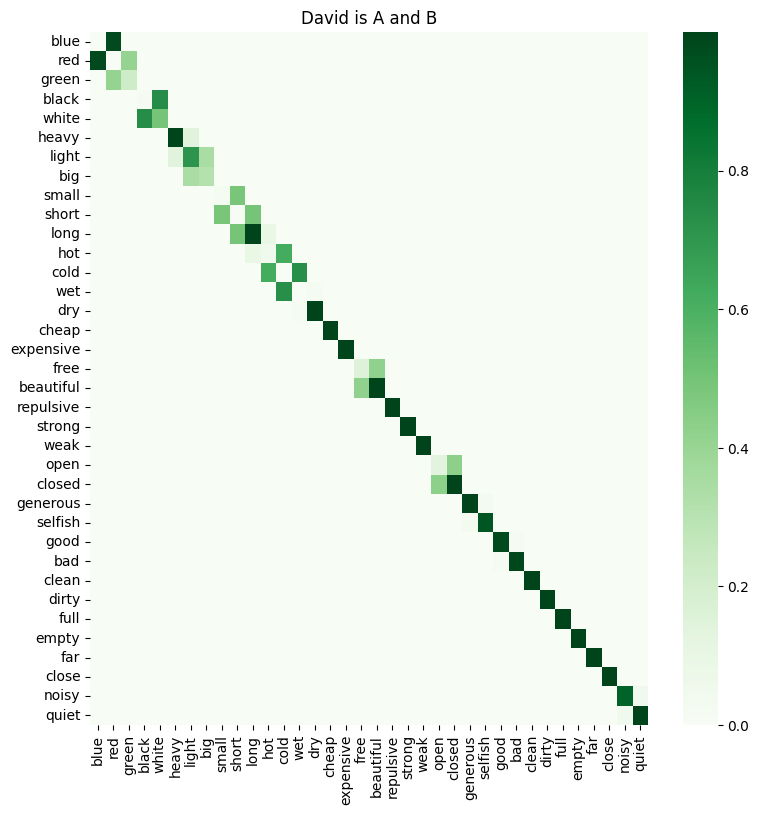

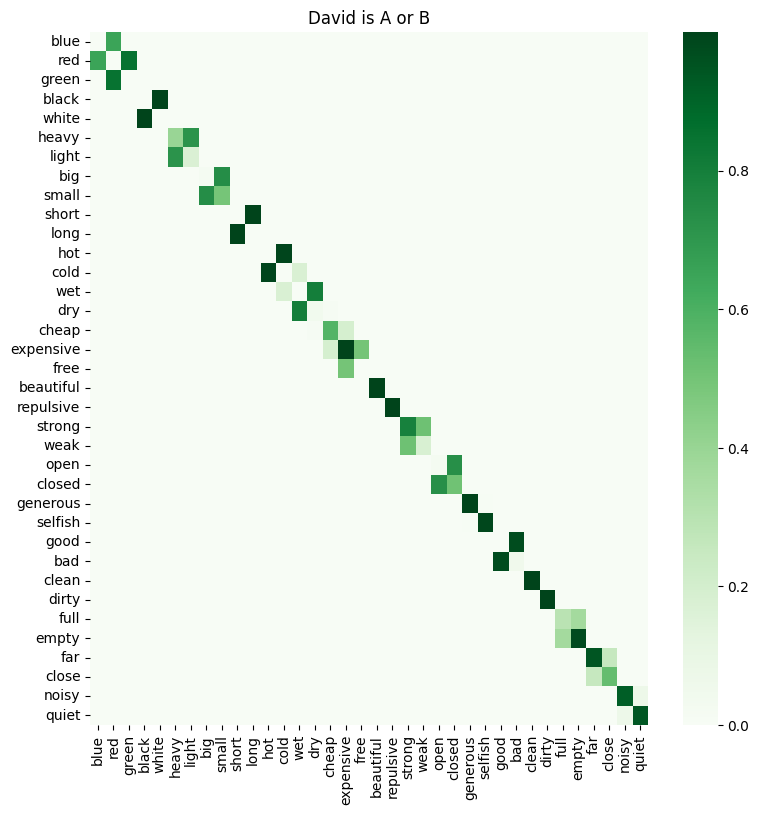

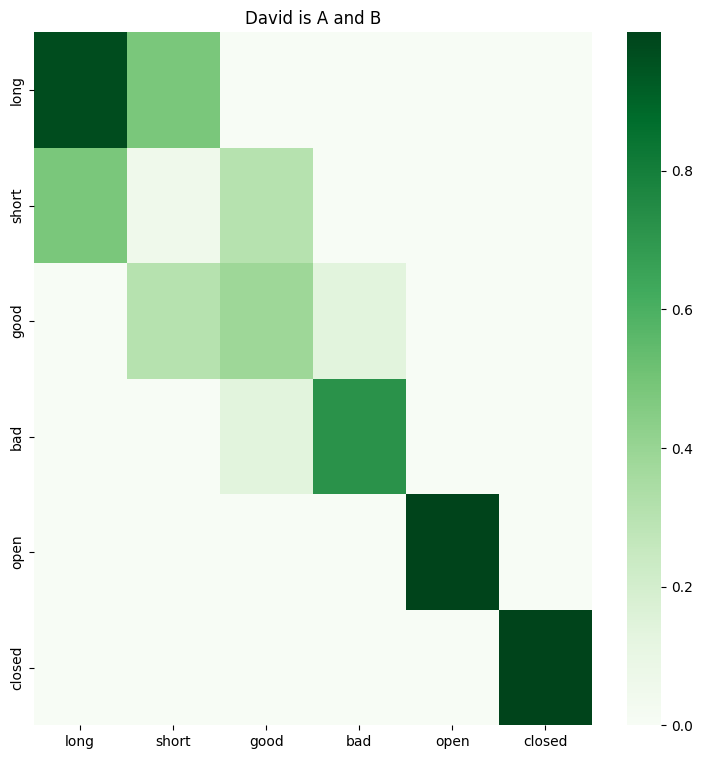

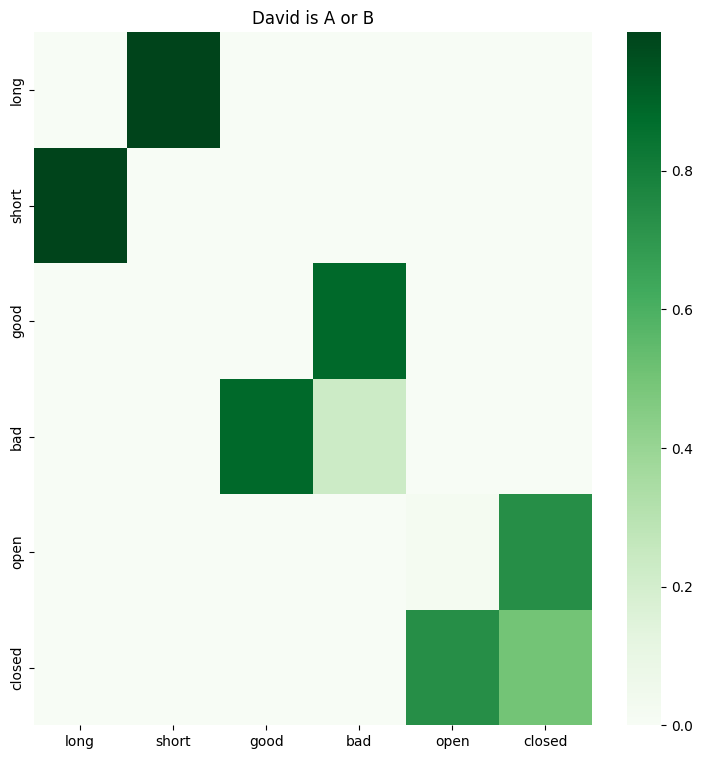

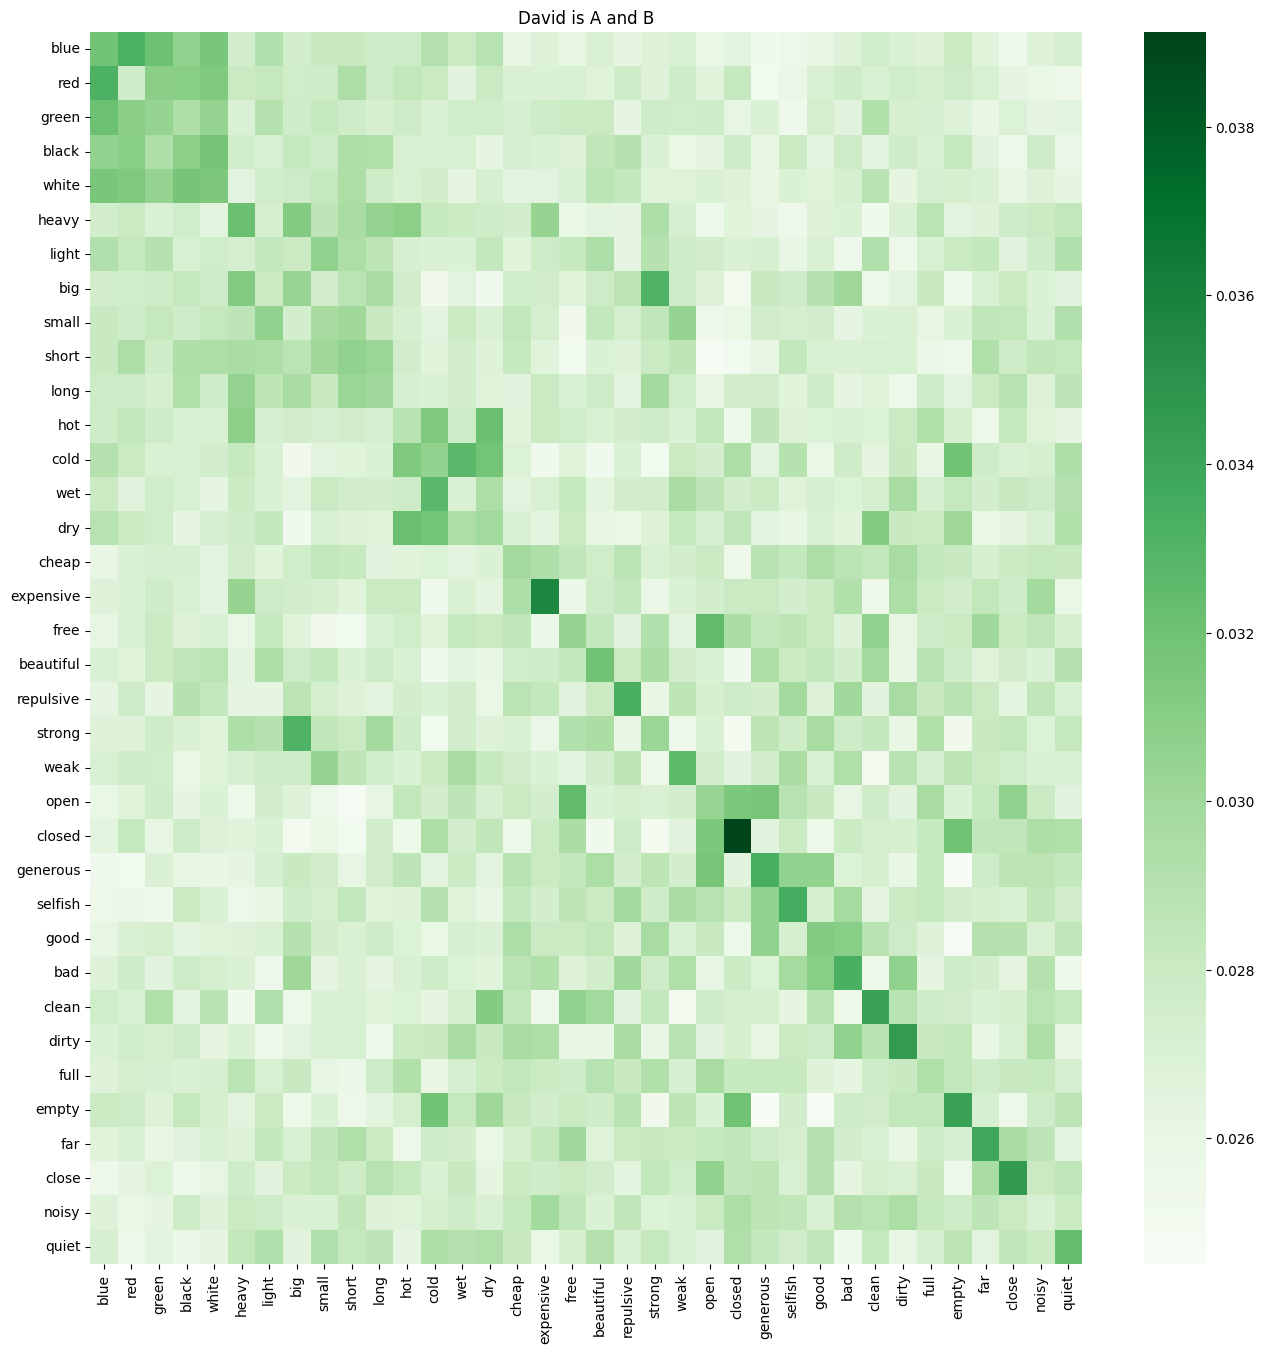

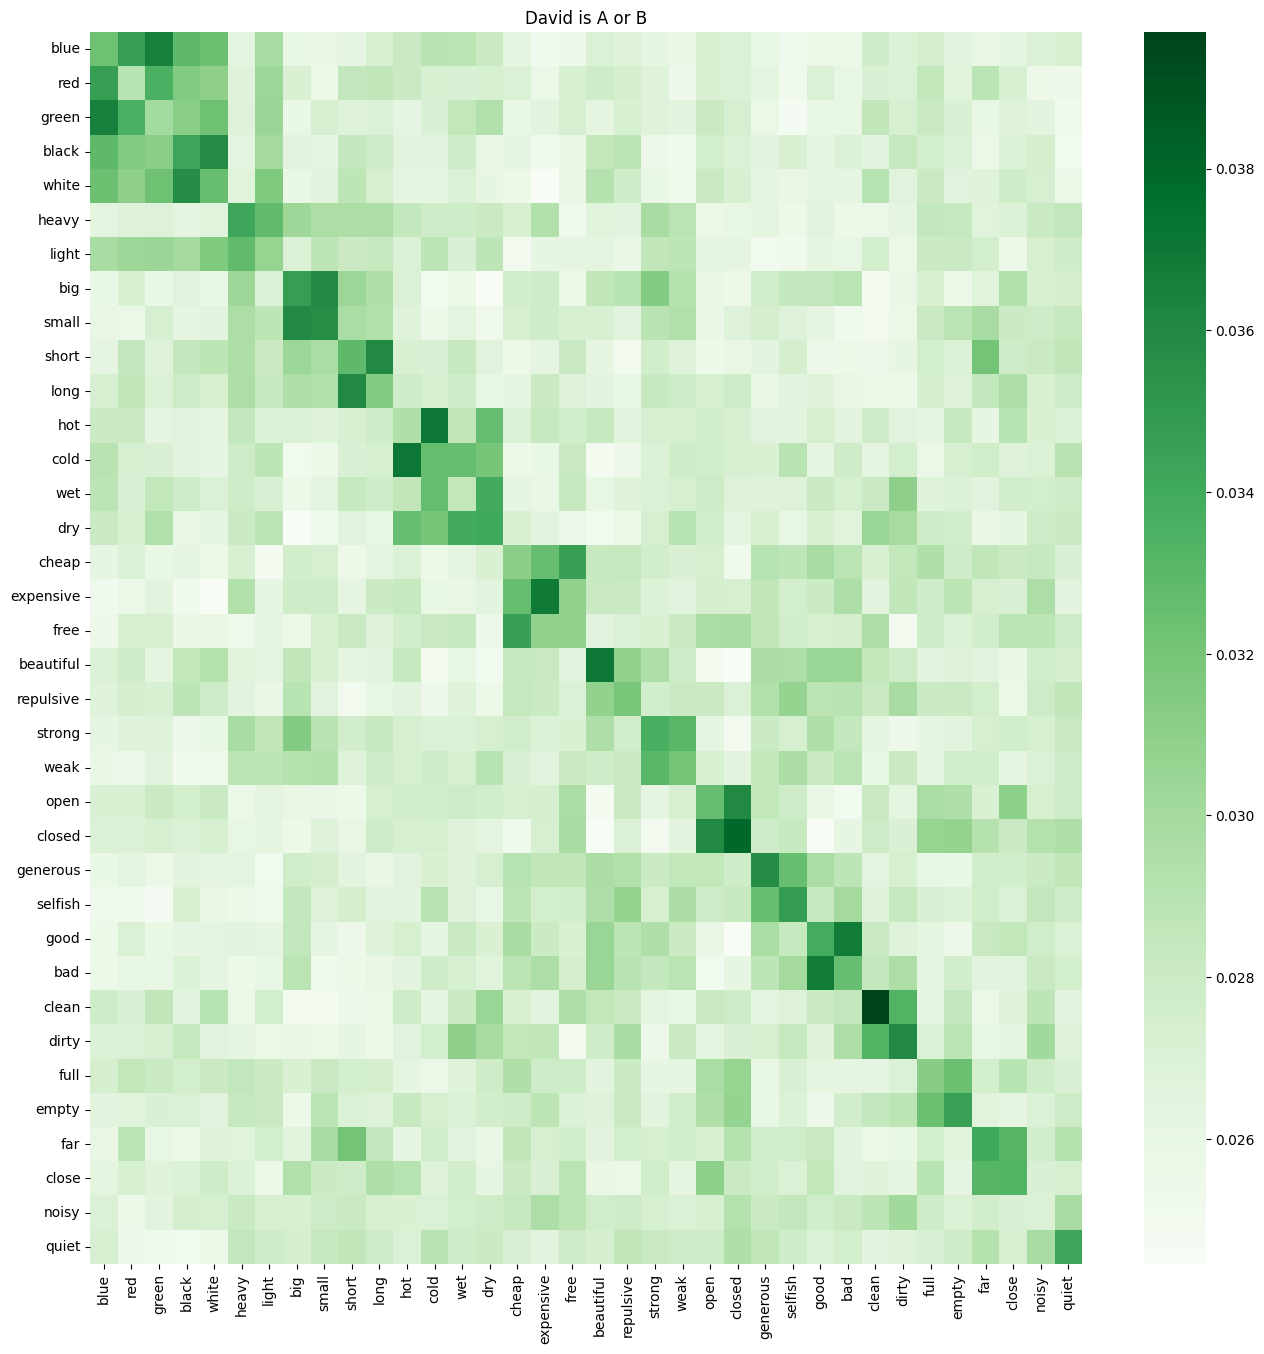

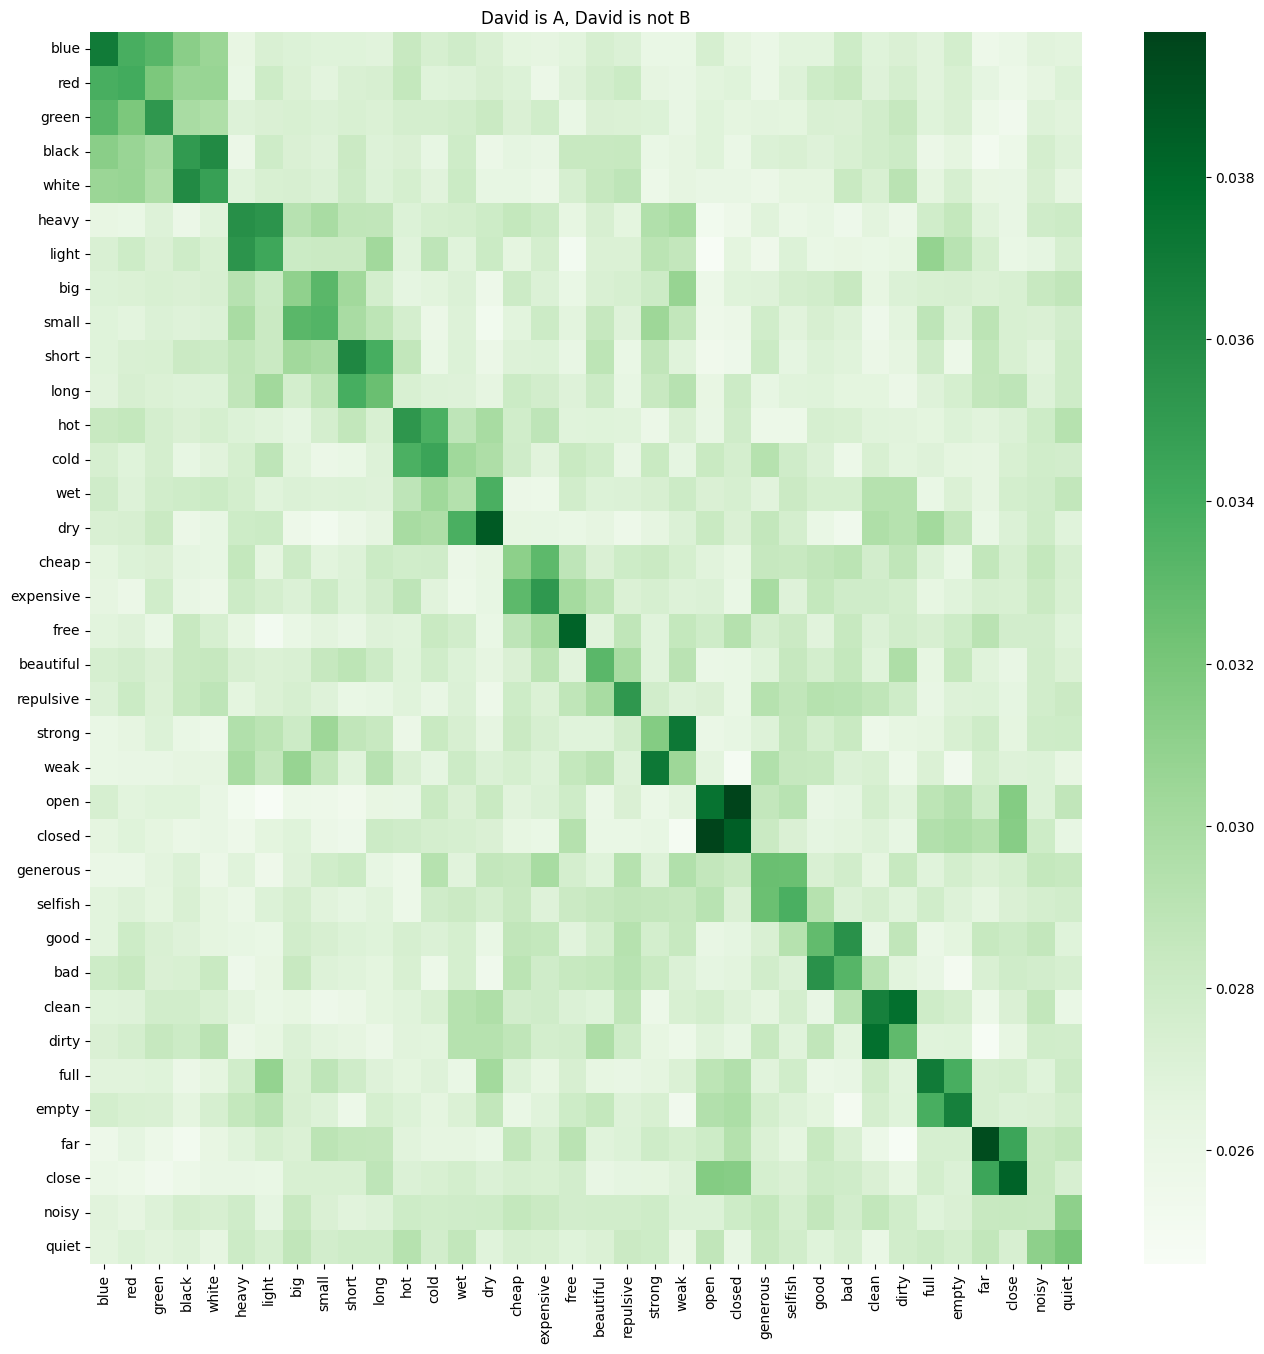

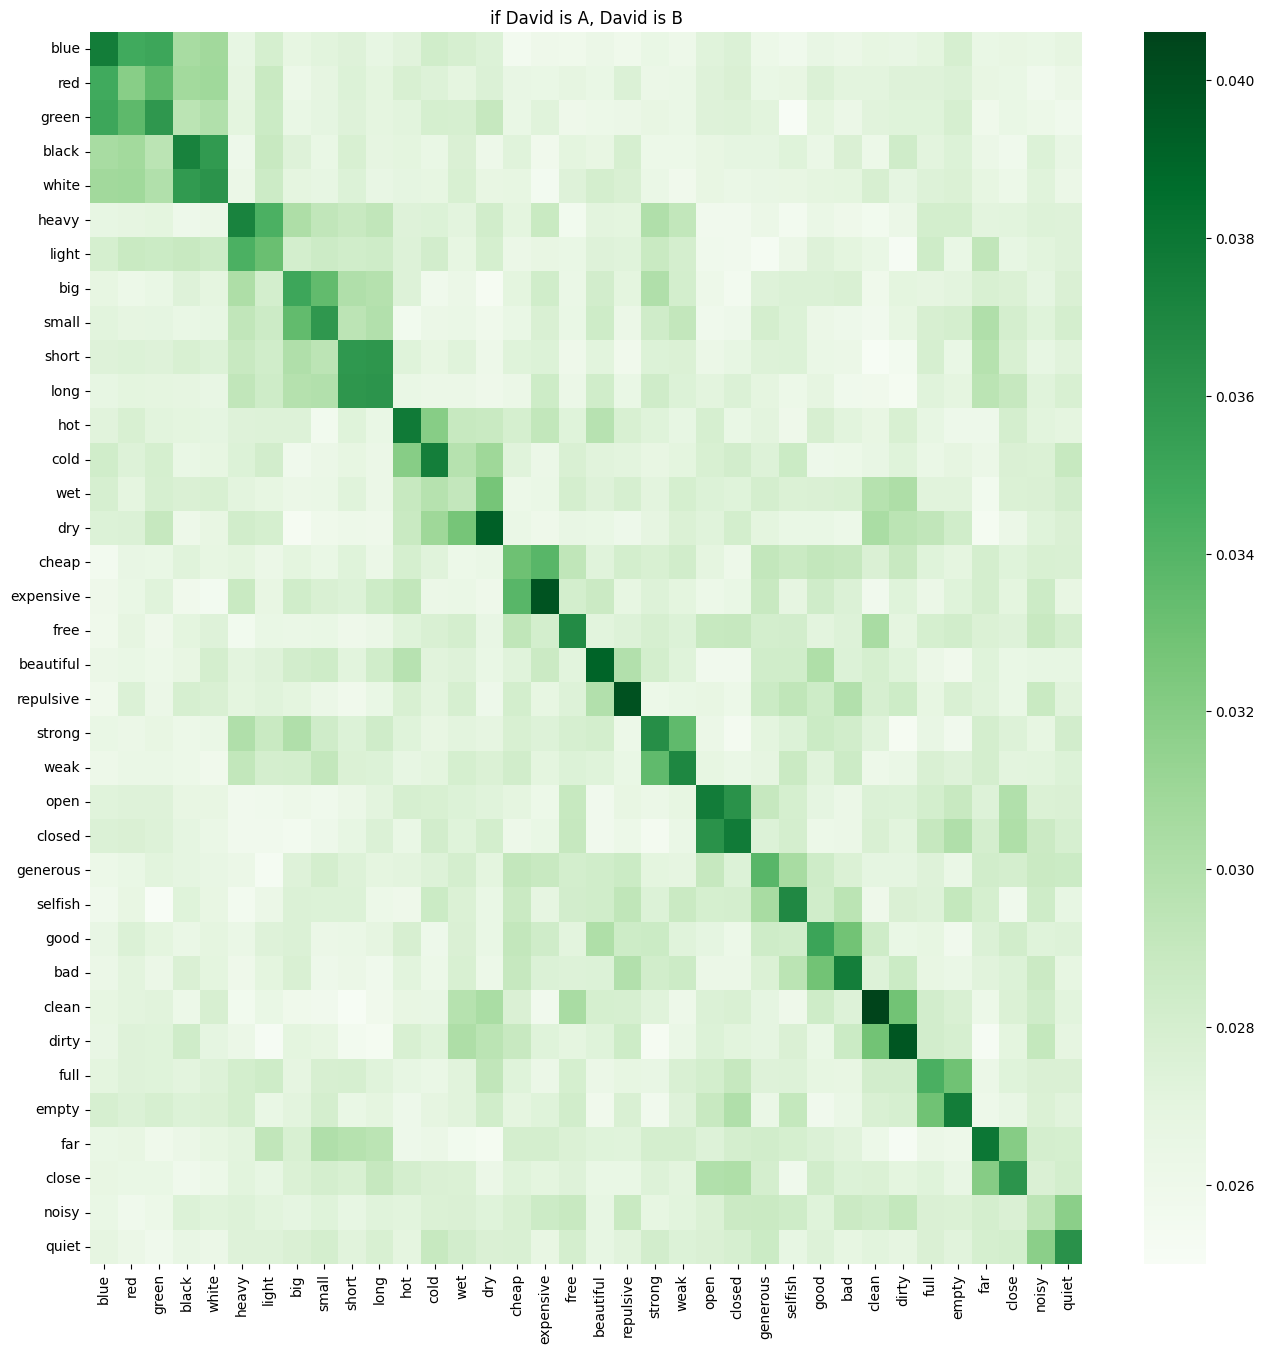

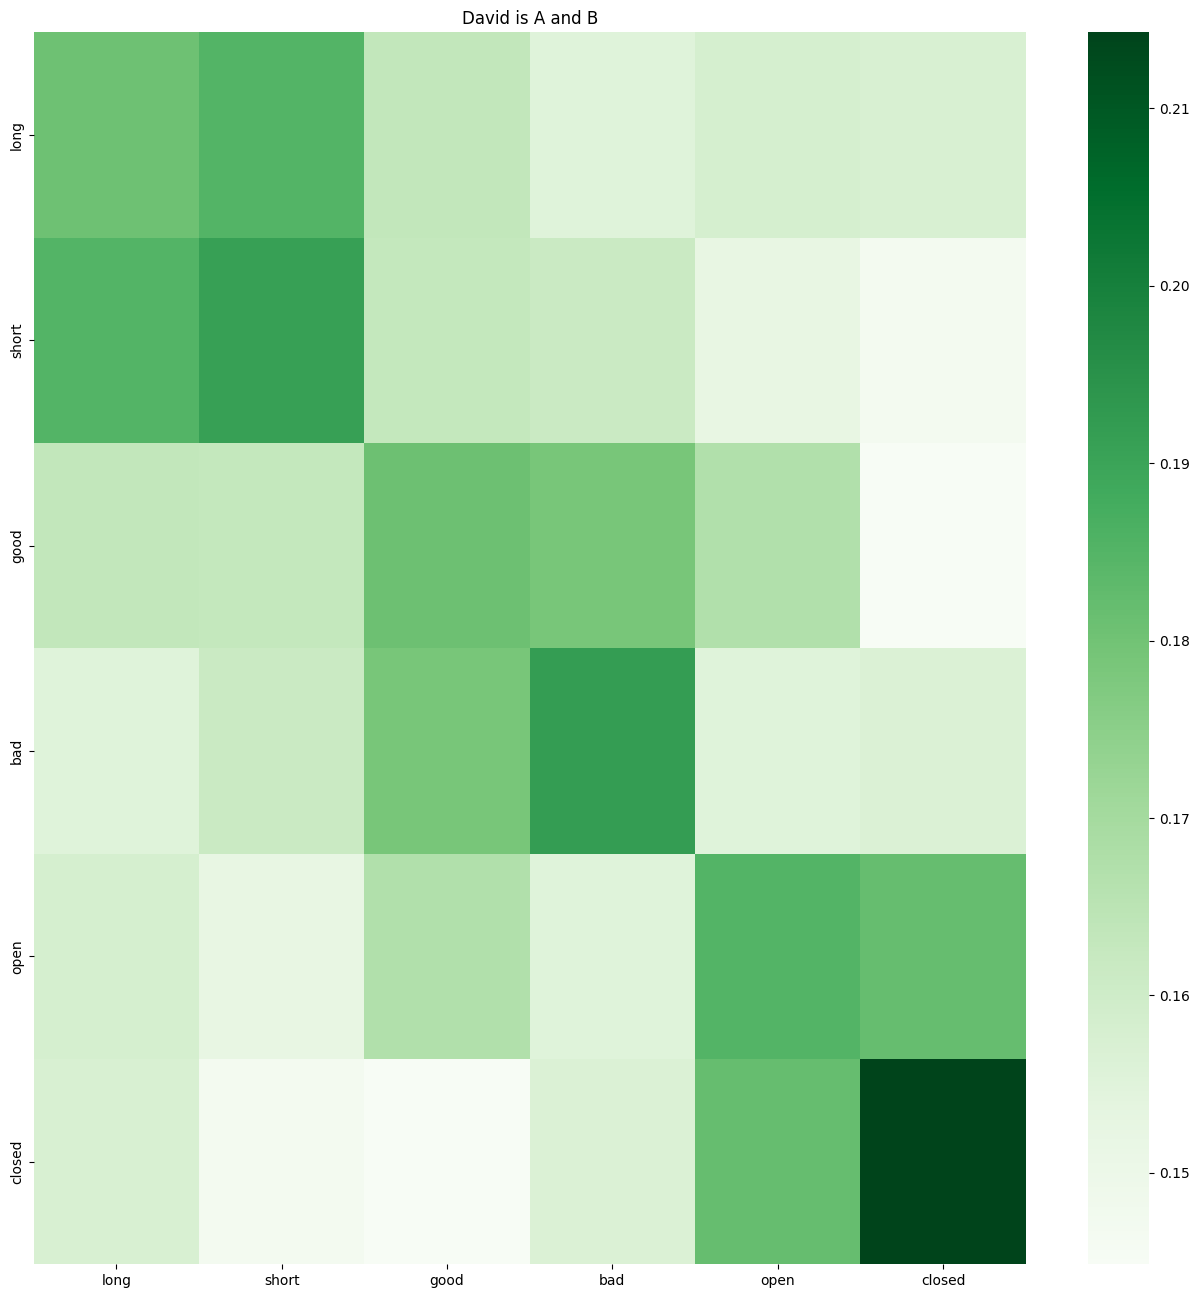

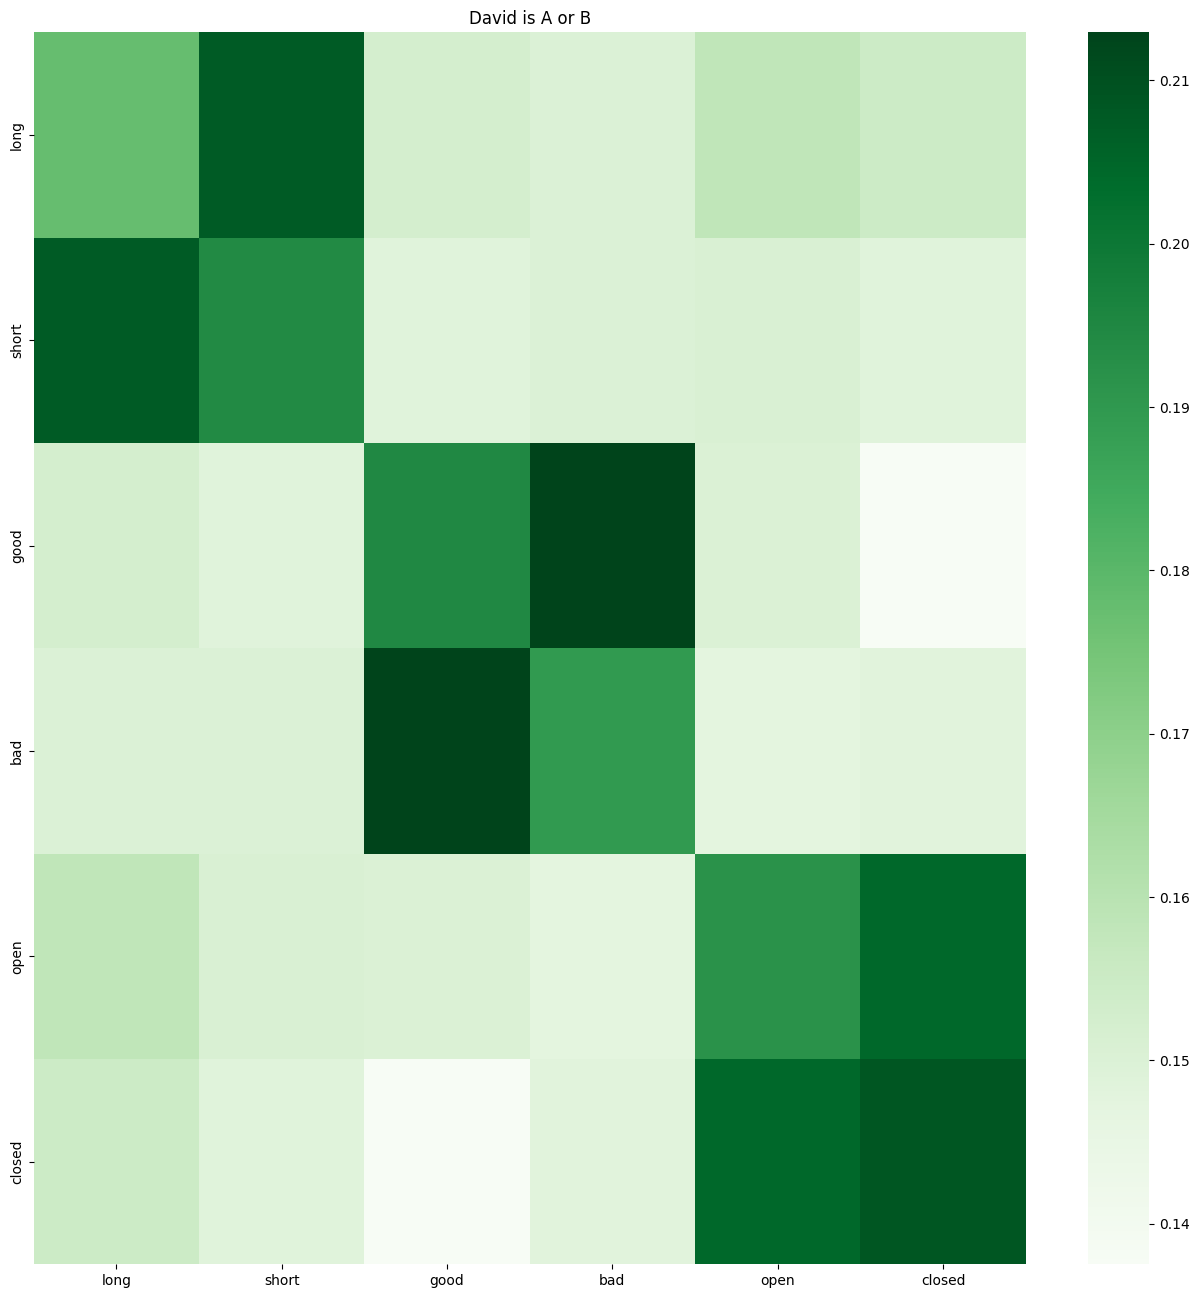

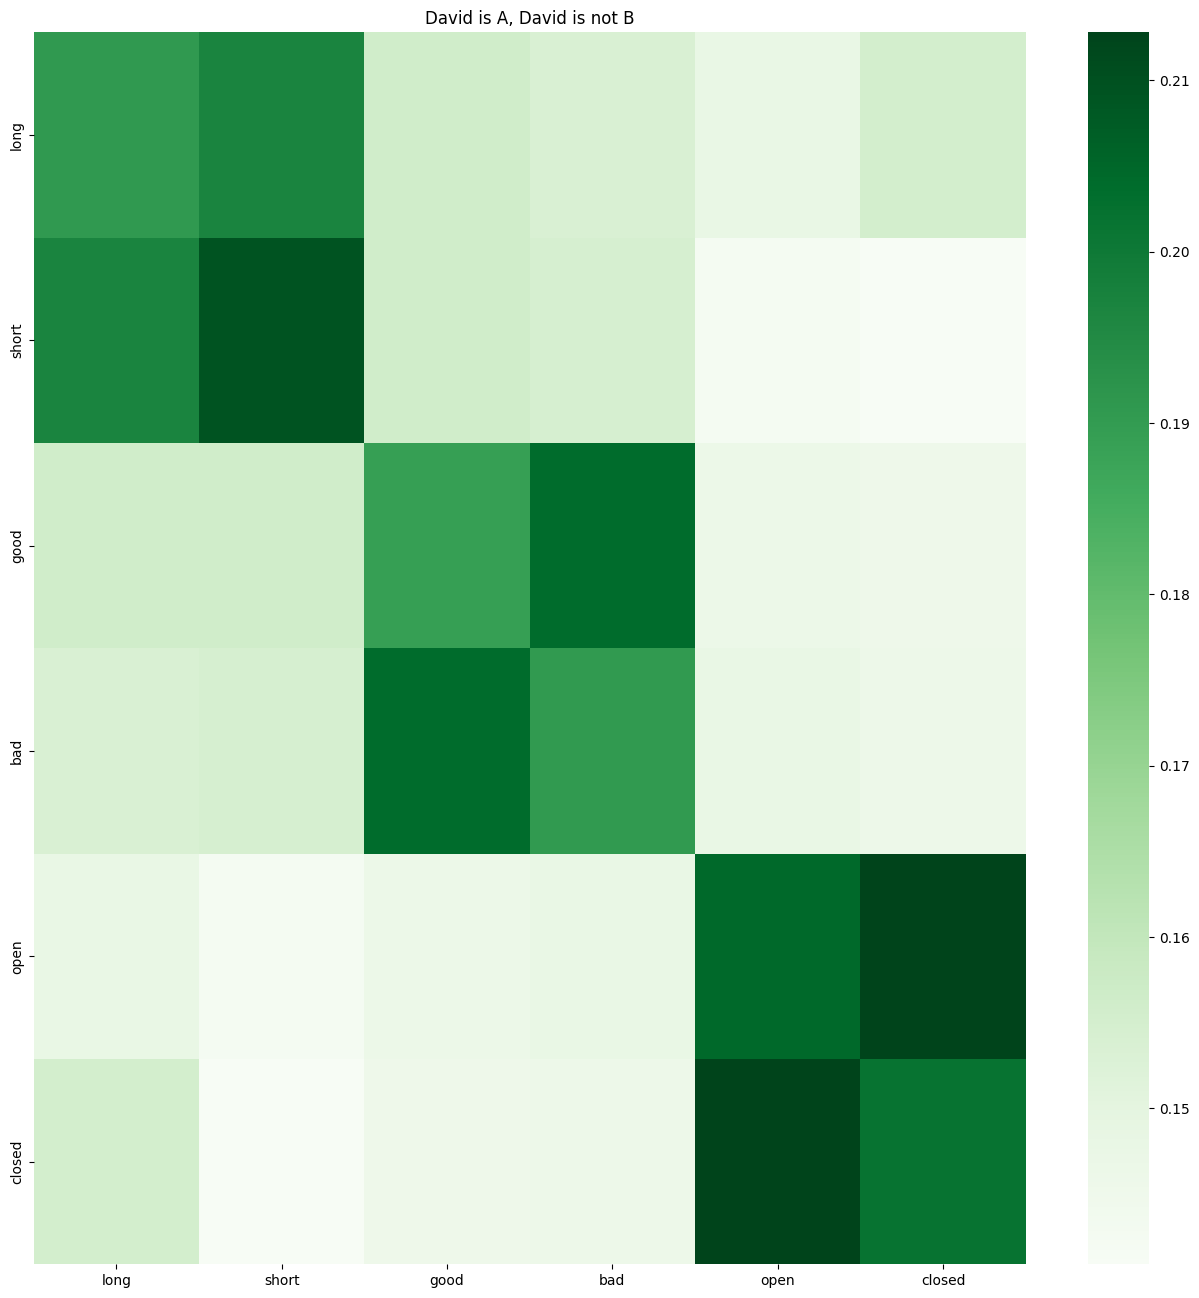

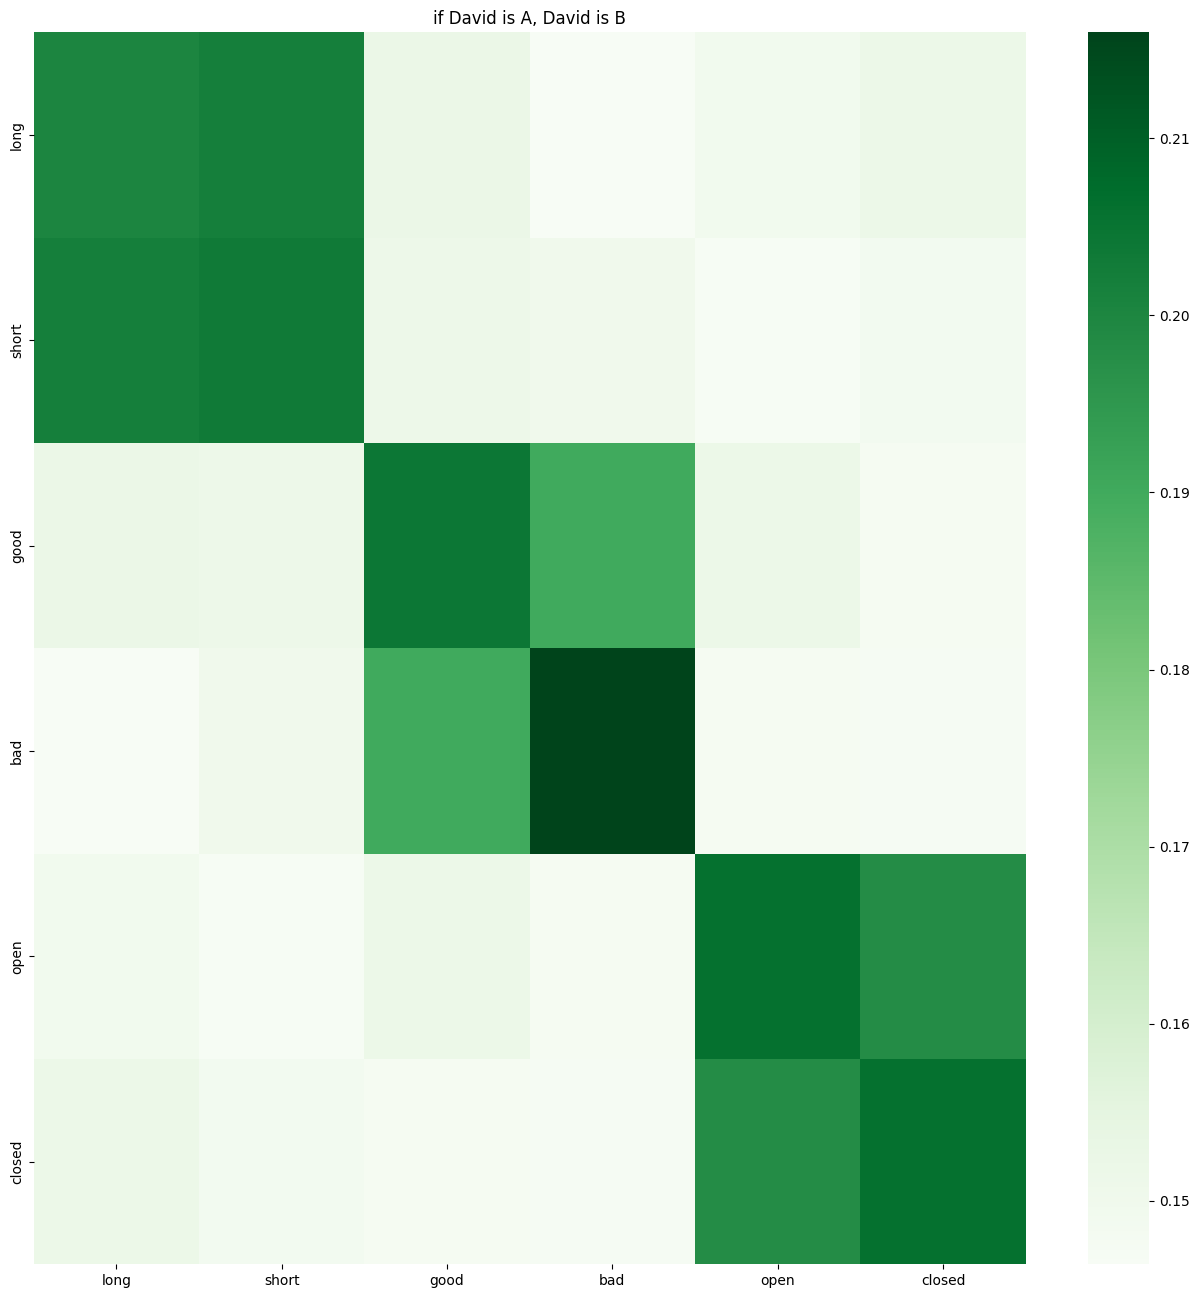

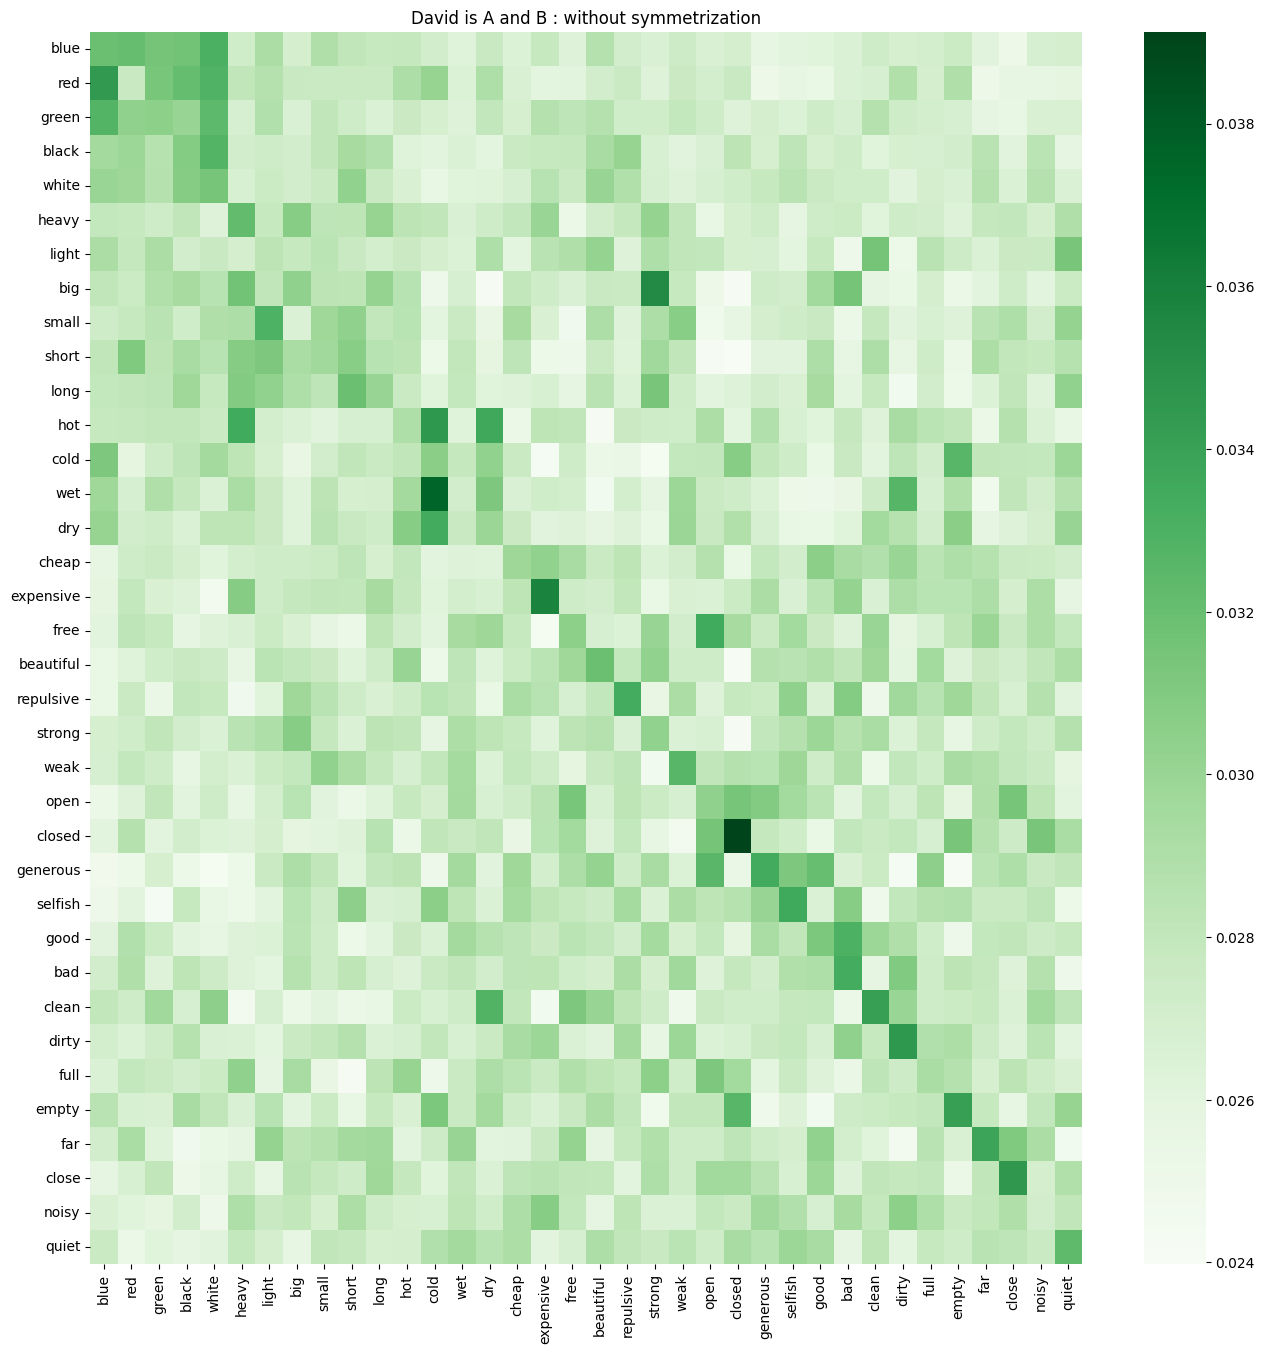

In [82]:
masked_heatmap(subject, adjectives, "SUBJECT is ADJ_A and", title=f"{subject} is A and B")
masked_heatmap(subject, adjectives, "SUBJECT is ADJ_A or", title=f"{subject} is A or B")

# > à plot
masked_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A and", title=f"{subject} is A and B")
masked_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A or", title=f"{subject} is A or B")

# > à plot en grand ET en petit
exp_heatmap(subject, adjectives, "SUBJECT is ADJ_A and", title=f"{subject} is A and B")
exp_heatmap(subject, adjectives, "SUBJECT is ADJ_A or", title=f"{subject} is A or B")
exp_heatmap(subject, adjectives, "SUBJECT is ADJ_A, SUBJECT is not", title=f"{subject} is A, {subject} is not B")
exp_heatmap(subject, adjectives, "if SUBJECT is ADJ_A, then SUBJECT is", title=f"if {subject} is A, {subject} is B")

exp_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A and", title=f"{subject} is A and B")
exp_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A or", title=f"{subject} is A or B")
exp_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A but", title=f"{subject} is A or B")
exp_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A, SUBJECT is not", title=f"{subject} is A, {subject} is not B")
exp_heatmap(subject, adjectives_subset, "if SUBJECT is ADJ_A, then SUBJECT is", title=f"if {subject} is A, {subject} is B")

# > à plot
nosym_heatmap(subject, adjectives, "SUBJECT is ADJ_A and", title=f"{subject} is A and B : without symmetrization")

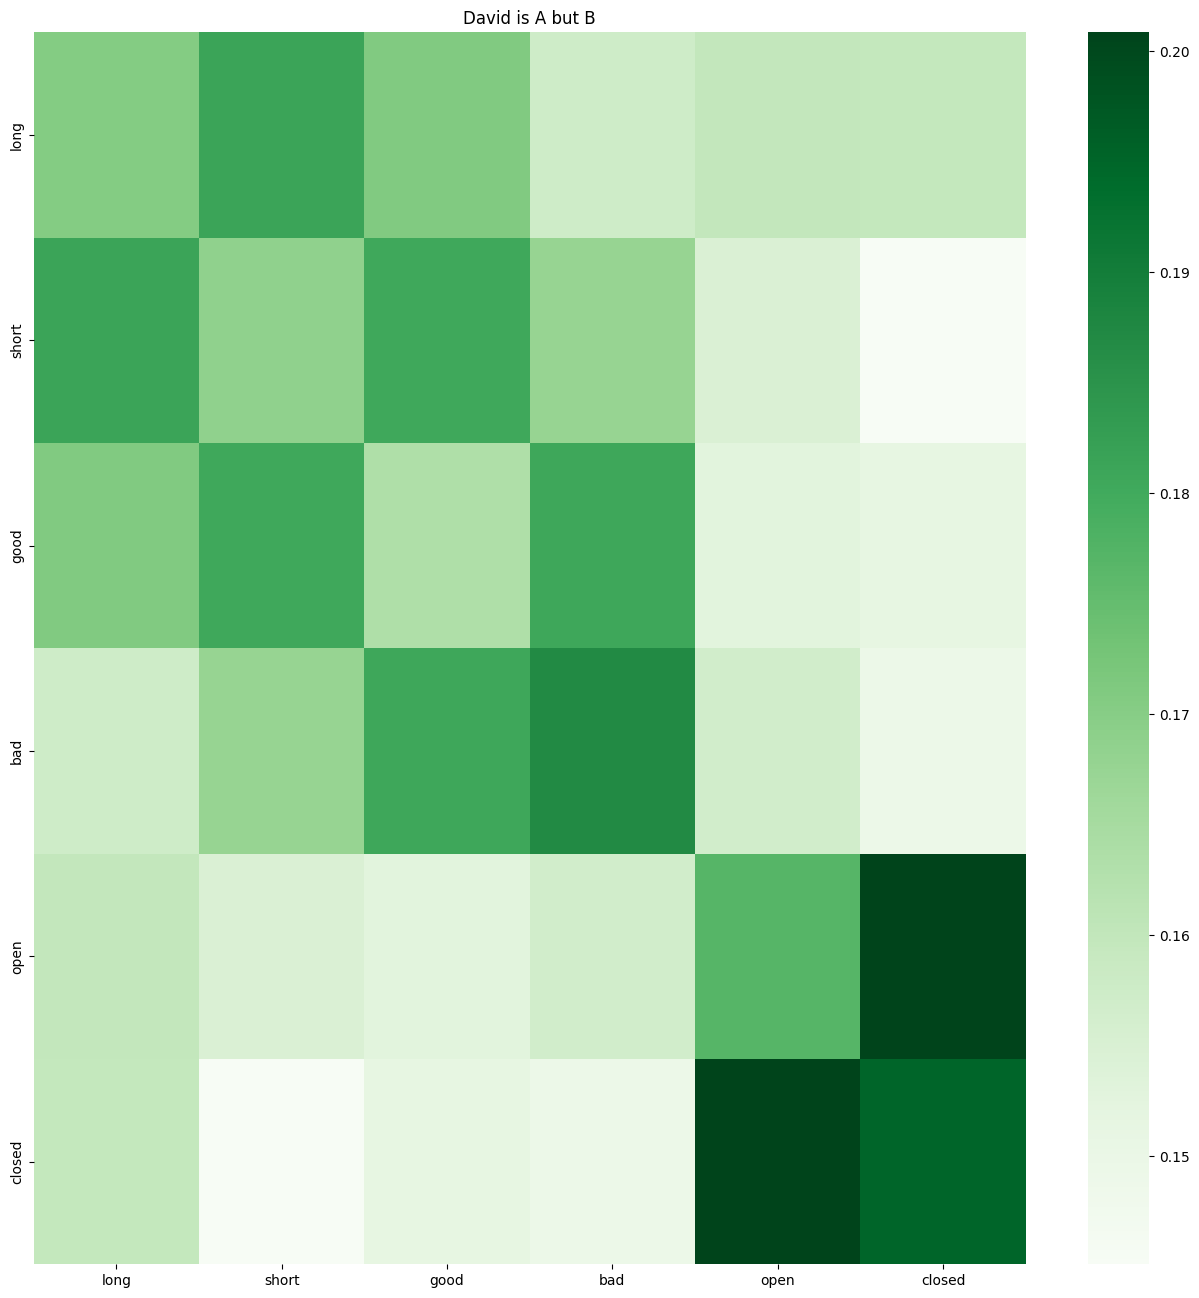

In [122]:
exp_heatmap(subject, adjectives_subset, "SUBJECT is ADJ_A but", title=f"{subject} is A but B")

## Part III : Categorization

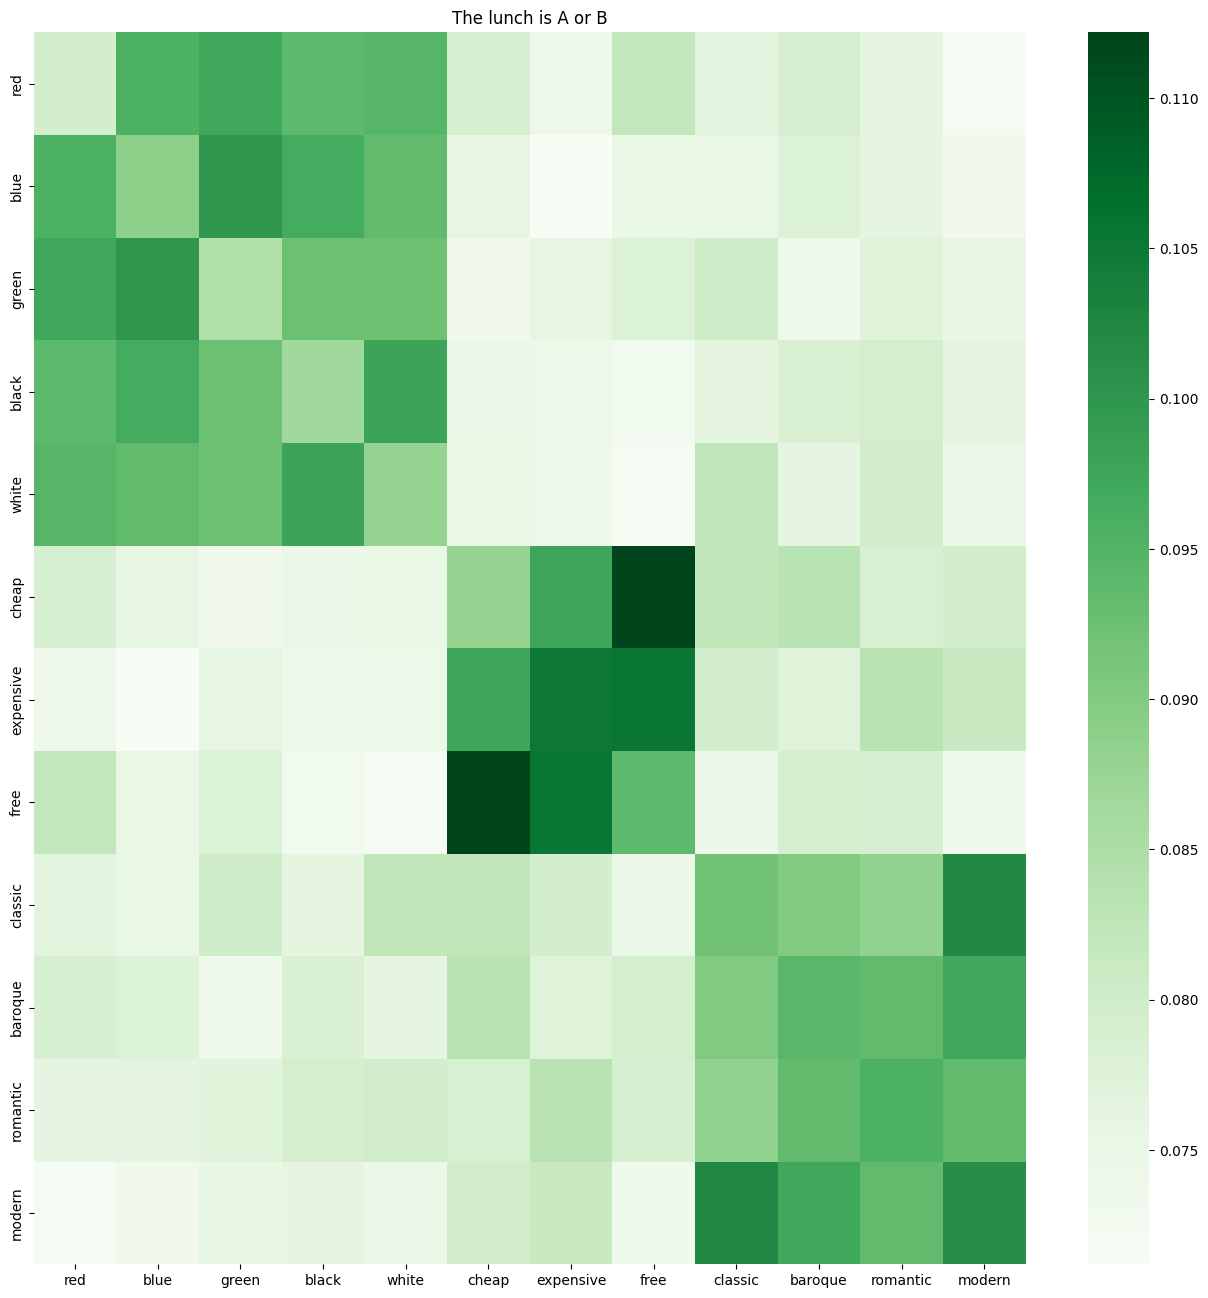

In [63]:
subject = "The lunch"
adjectives_base = [["red", "blue", "green", "black", "white"],
                   ["cheap", "expensive", "free"],
                   ["classic", "baroque", "romantic", "modern"]]
adjectives = [x for l in adjectives_base for x in l]


exp_heatmap(subject, adjectives, "SUBJECT is ADJ_A or", title=f"{subject} is A or B")

## Part IV : Synonyms

In [124]:
subject = "David"
adjectives_base = [["kind", "loving", "friendly"],
                   ["mean", "greedy", "selfish"],
                   ["strong", "robust", "solid"],
                   ["weak", "fragile", "powerless"]]
adjectives = [x for l in adjectives_base for x in l]

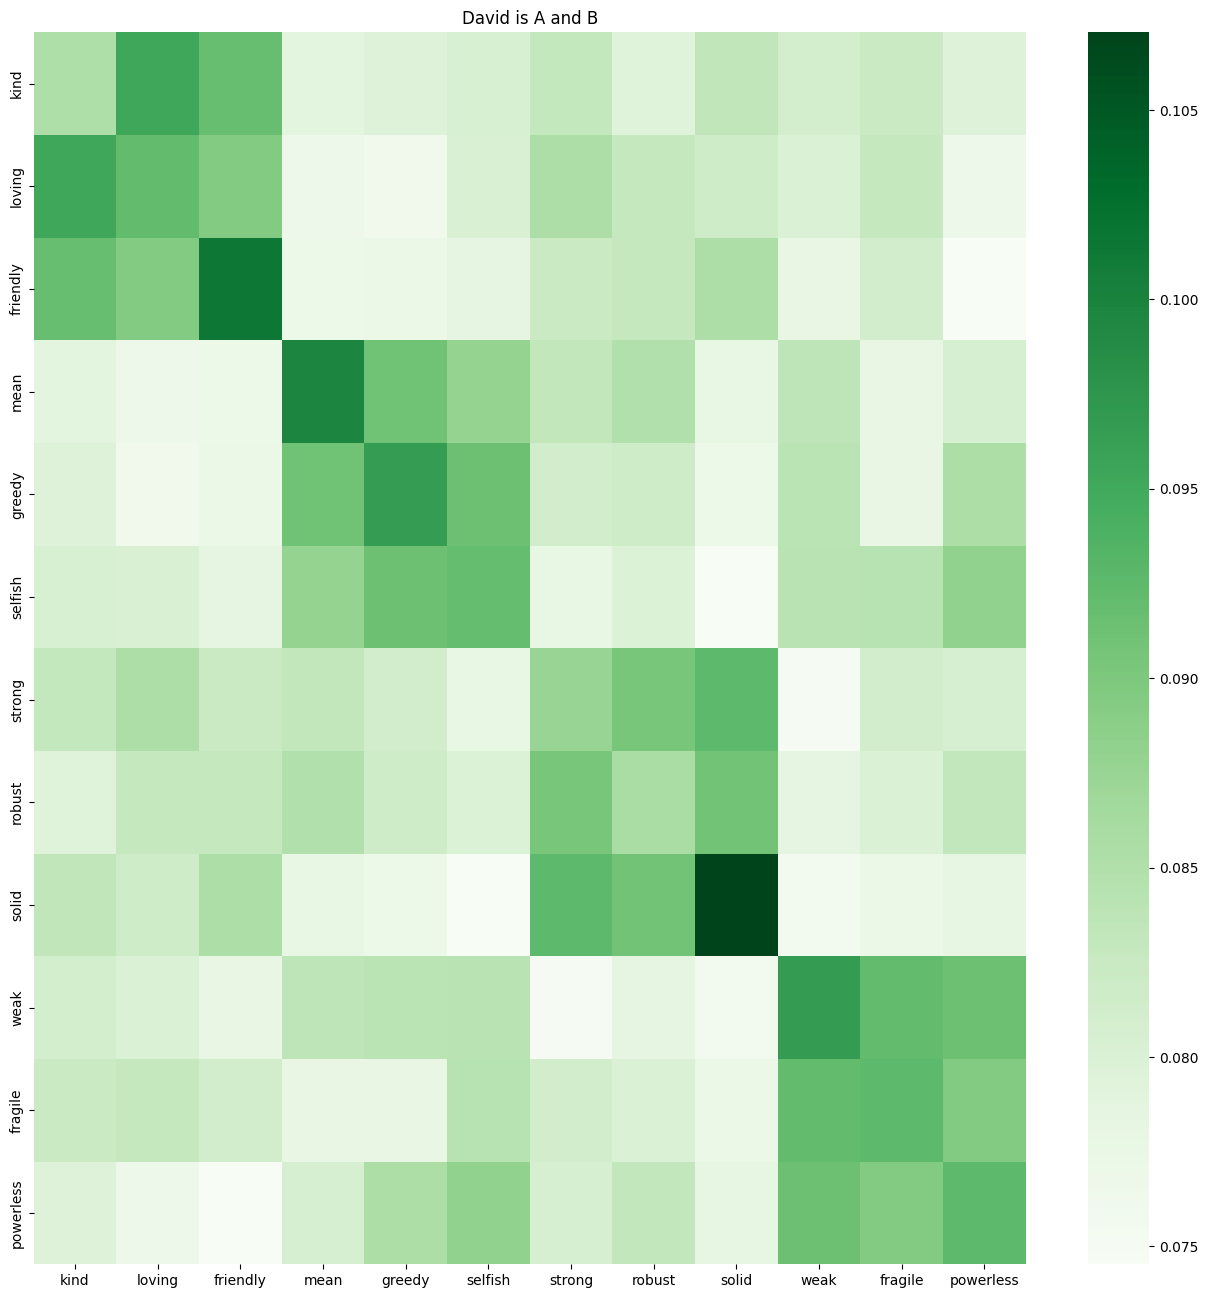

In [73]:
exp_heatmap(subject, adjectives, "SUBJECT is ADJ_A and", title=f"{subject} is A and B")

In [77]:
def reduced_heatmap(subject, adjectives, query="SUBJECT is ADJ_A, however SUBJECT is", title=None):
    array = np.zeros((len(adjectives), len(adjectives)))
    for a, adj_a in enumerate(adjectives):
        selected = normalize(select_probas(get_probas(query, SUBJECT=subject, ADJ_A=adj_a), adjectives), tau=0.1)
        for b, adj_b in enumerate(selected):
            array[a, b] = selected[adj_b]
    array = array / array.sum(axis=0)
    arr = (array + array.T)/2
    arr = np.array([[arr[3*i:3*i+3,3*j:3*j+3].mean() for j in range(arr.shape[1]//3)] for i in range(arr.shape[0]//3)])
    
    fig, ax = plt.subplots(figsize=(16, 16))
    r_adjectives = [adjectives[i*3] for i in range(len(adjectives)//3)]
    seaborn.heatmap(arr, xticklabels=r_adjectives, yticklabels=r_adjectives, cmap="Greens", ax=ax)
    ax.set_title(title)
    plt.show()

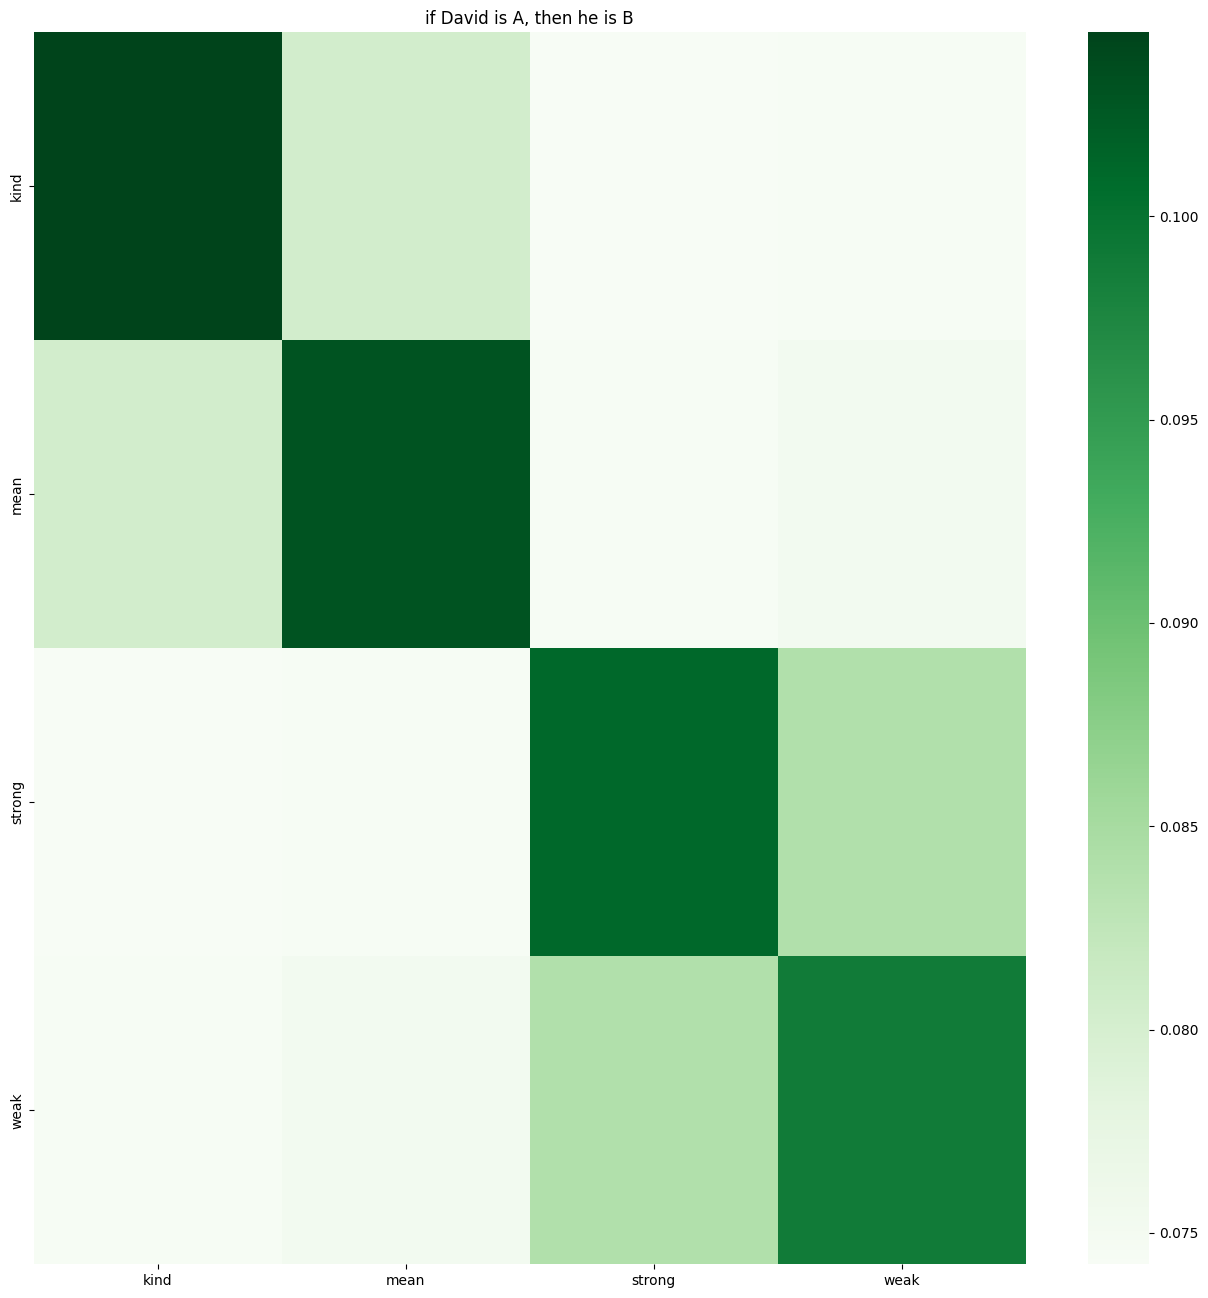

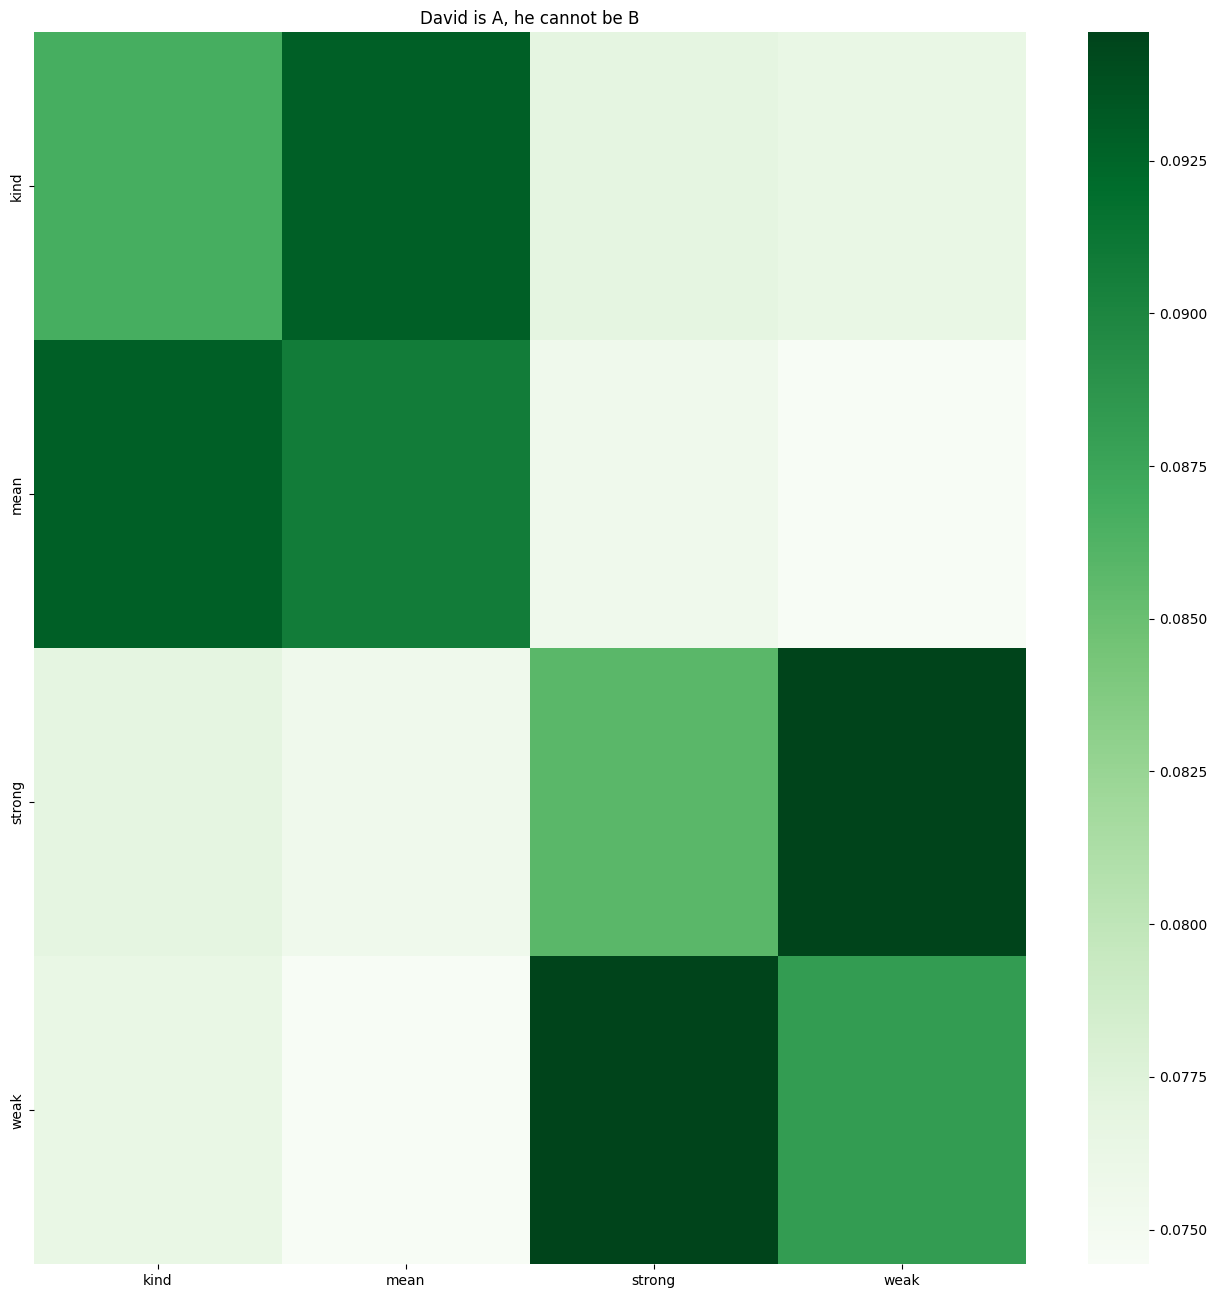

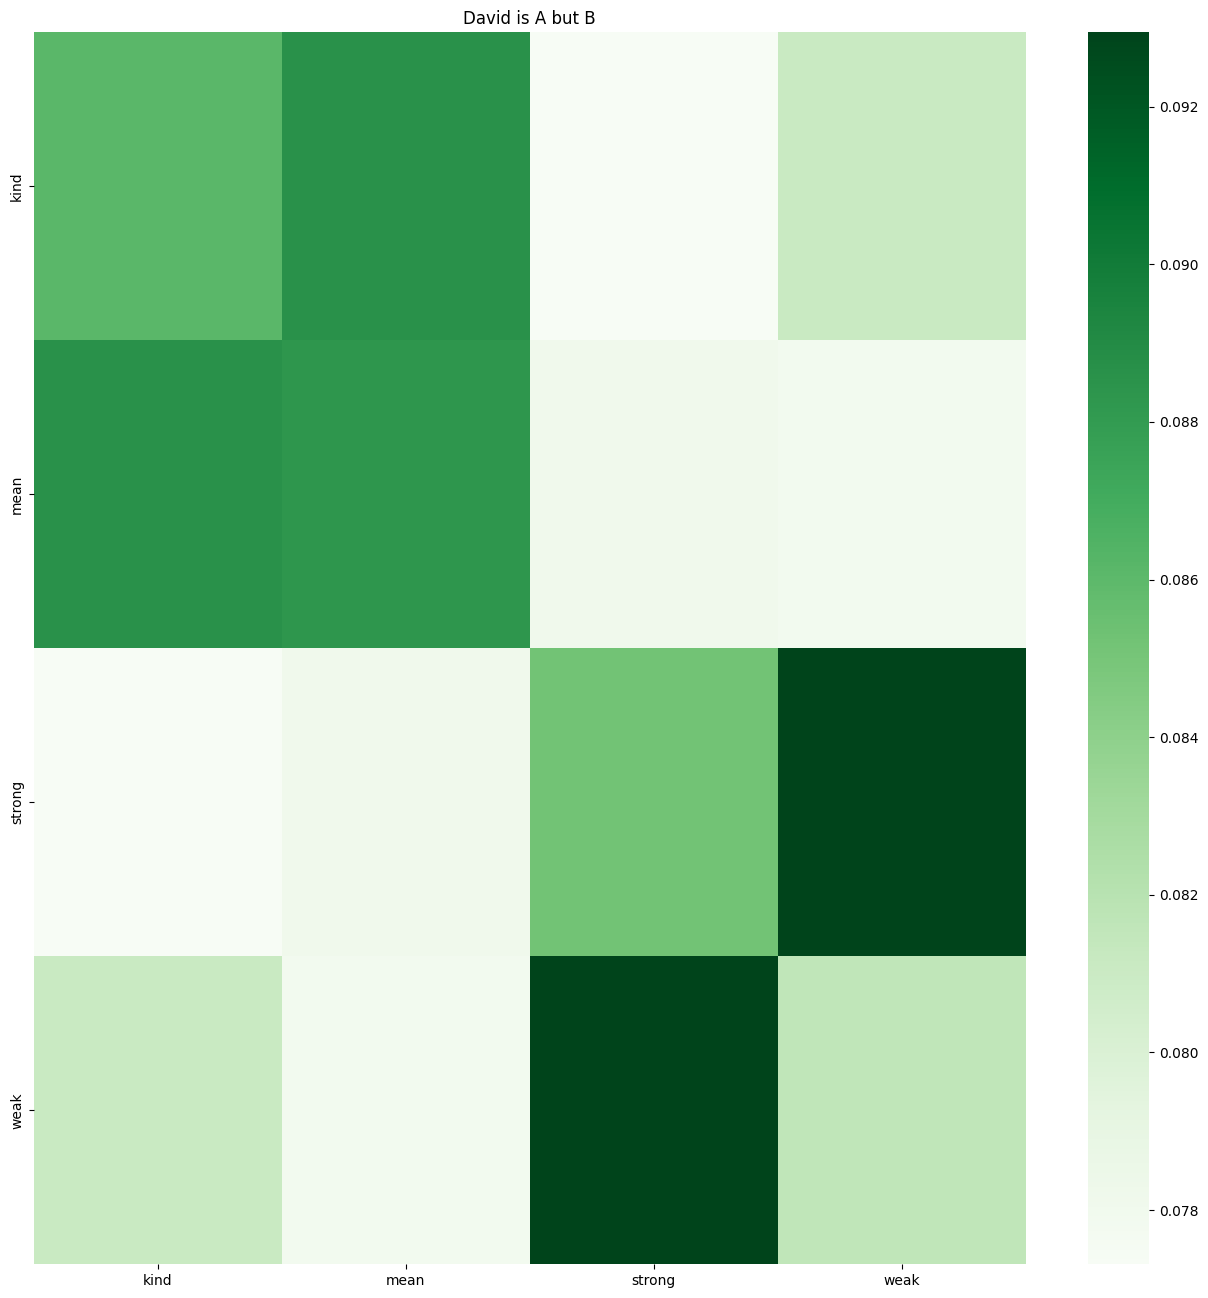

In [125]:
reduced_heatmap(subject, adjectives, "if SUBJECT is ADJ_A, then he is", title=f"if {subject} is A, then he is B")
reduced_heatmap(subject, adjectives, "SUBJECT is ADJ_A, he cannot be", title=f"{subject} is A, he cannot be B")
reduced_heatmap(subject, adjectives, "SUBJECT is ADJ_A but", title=f"{subject} is A but B")

## Part IV : Localization

In [ ]:
highest_n(get_probas("Marc is good and he is"), 10)

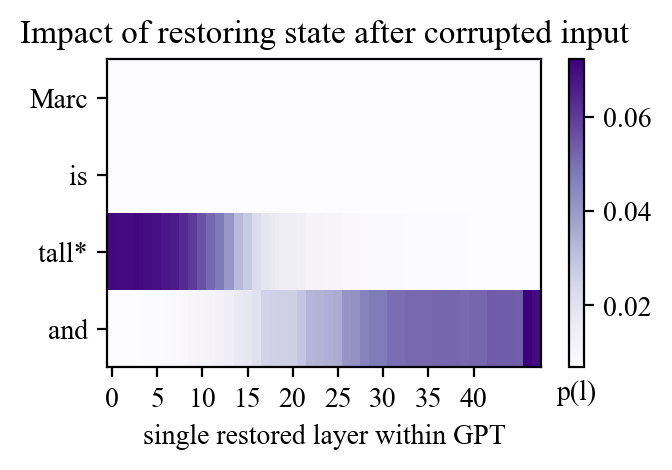

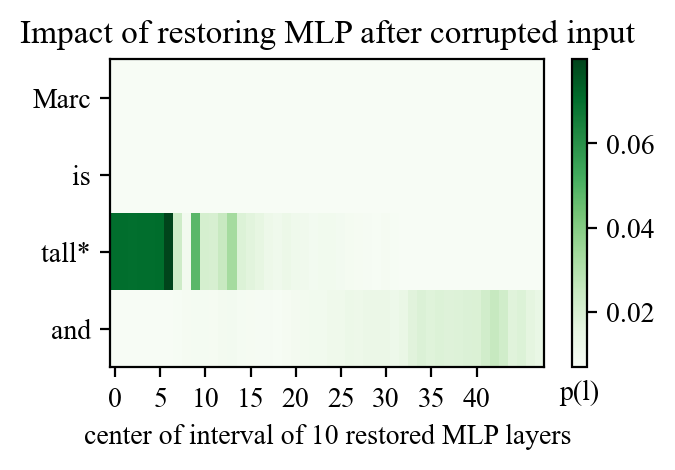

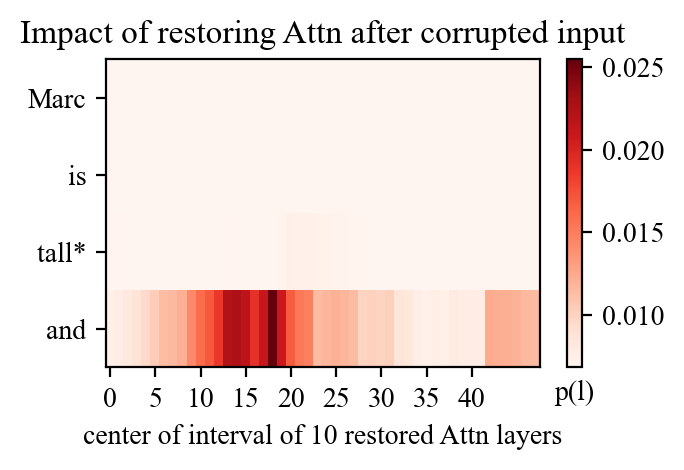

In [89]:
plot_all_flow(mt, "Marc is tall and", subject="tall", noise=0.1)

### Subject invariance

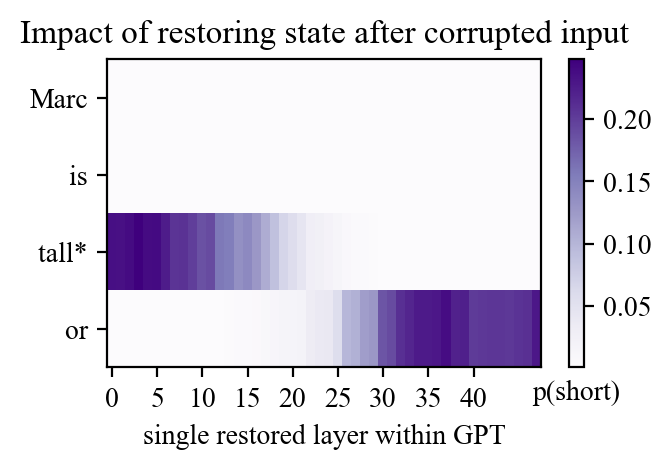

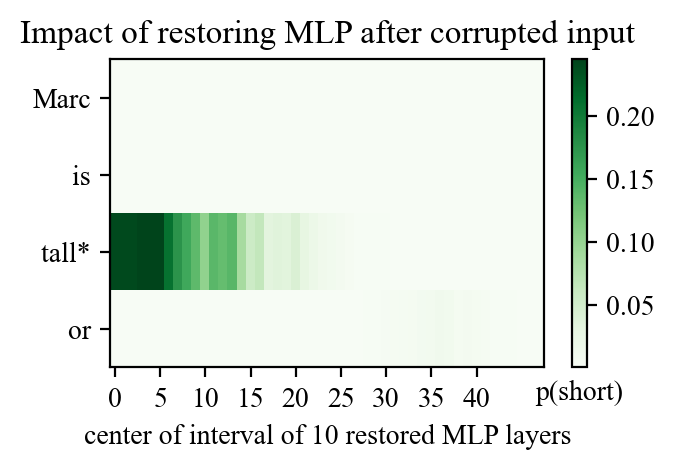

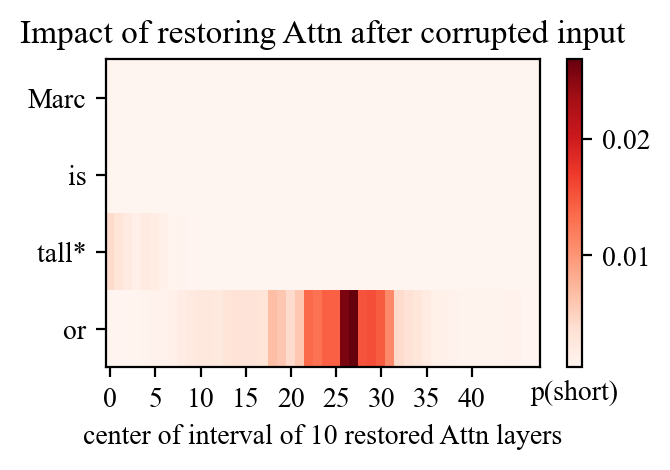

In [90]:
plot_all_flow(mt, "Marc is tall or", subject="tall", noise=0.3)

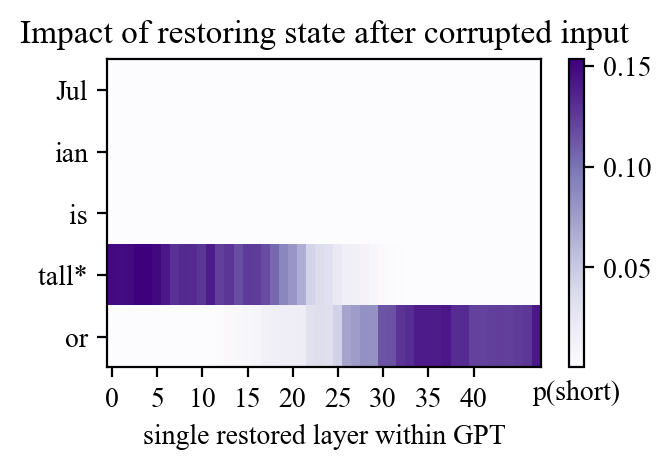

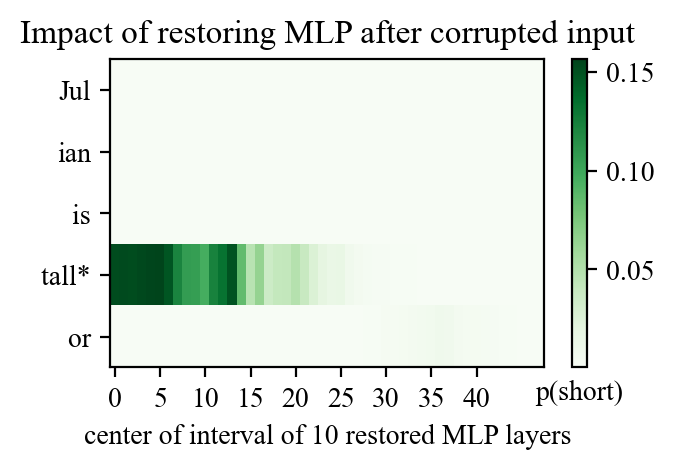

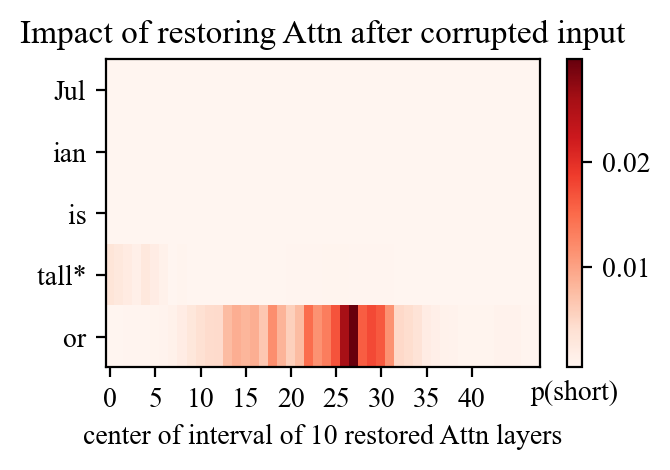

In [91]:
plot_all_flow(mt, "Julian is tall or", subject="tall", noise=0.3)

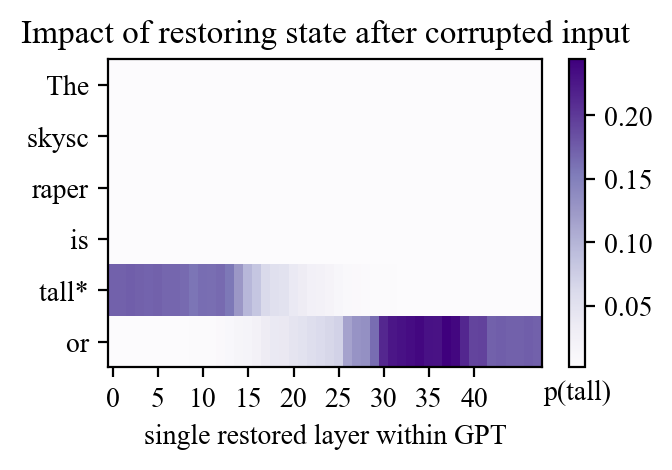

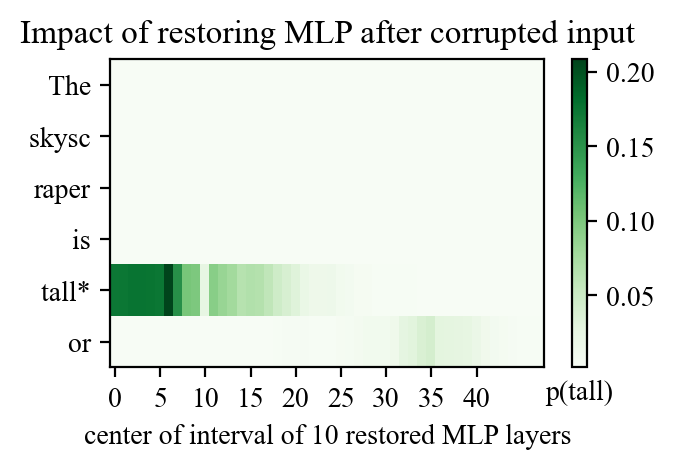

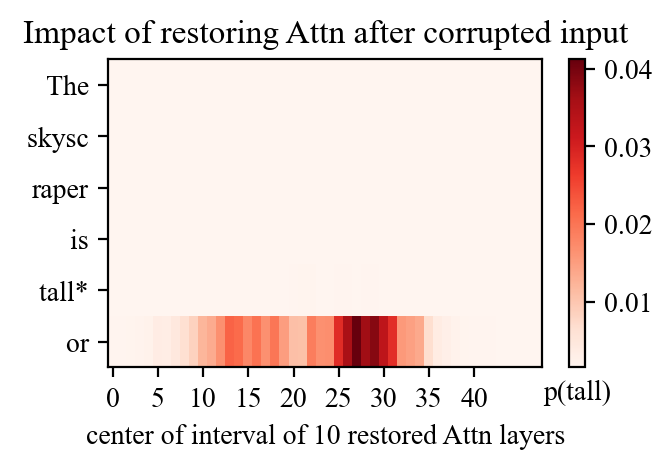

In [92]:
plot_all_flow(mt, "The skyscraper is tall or", subject="tall", noise=0.3)

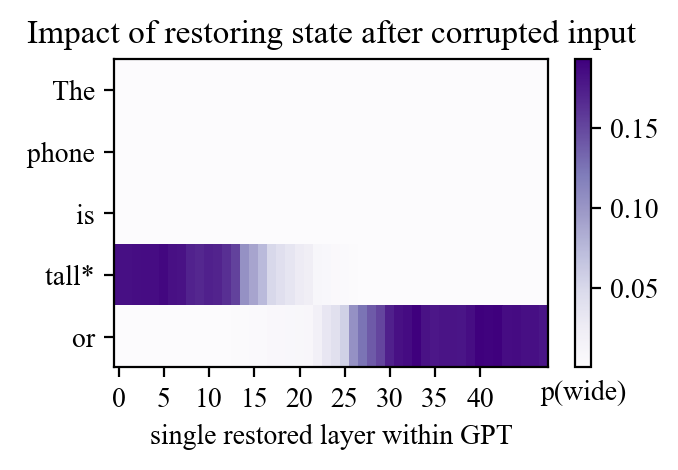

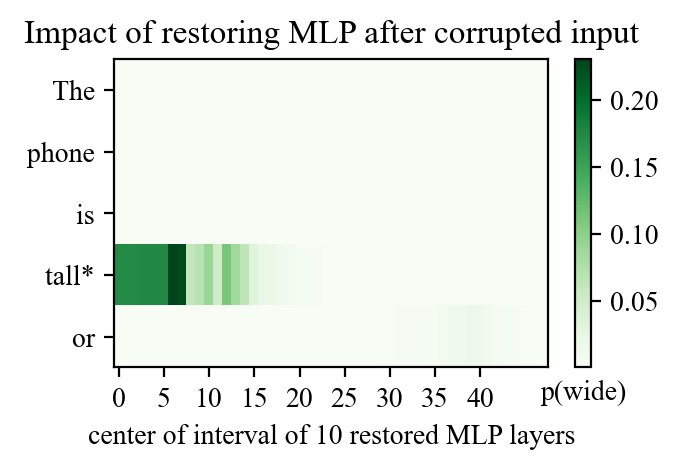

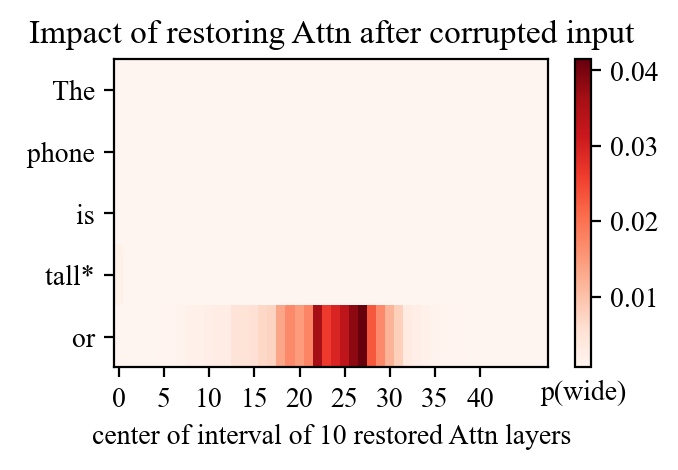

In [93]:
plot_all_flow(mt, "The phone is tall or", subject="tall", noise=0.3)

## Comparison between or, and, but, ...

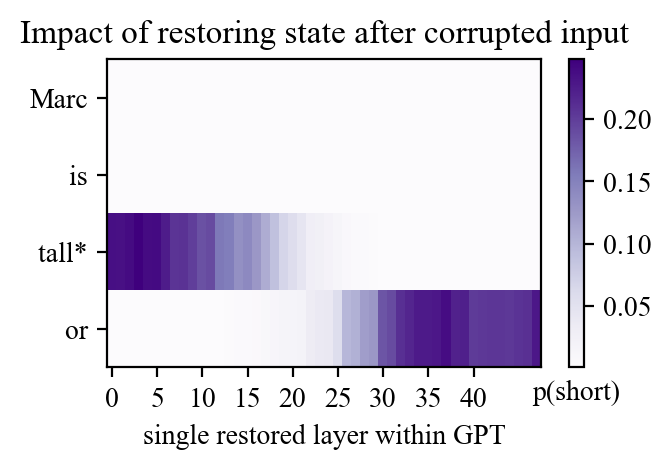

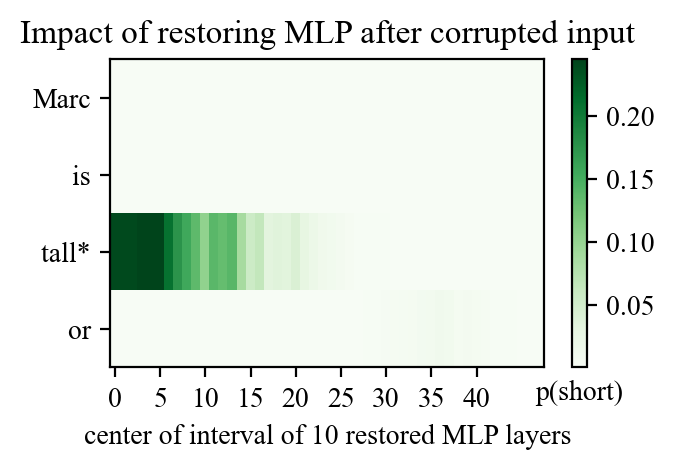

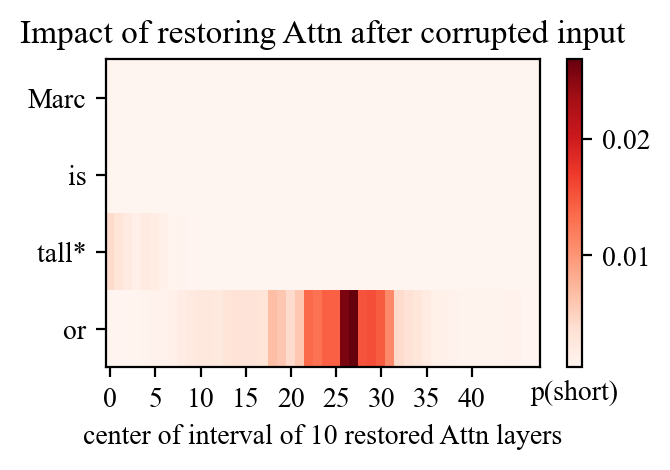

In [126]:
plot_all_flow(mt, "Marc is tall or", subject="tall", noise=0.3)

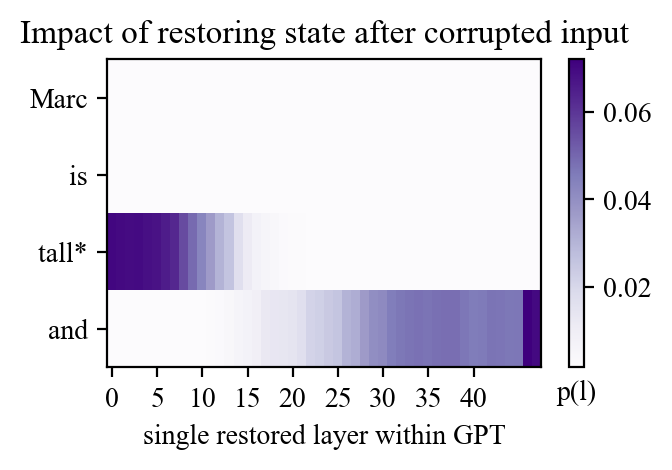

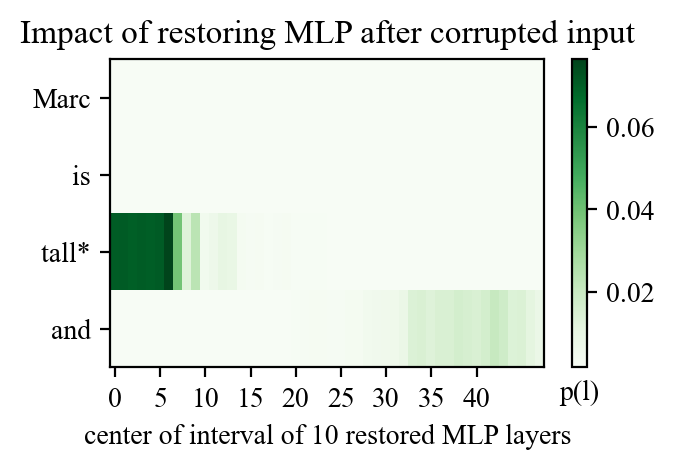

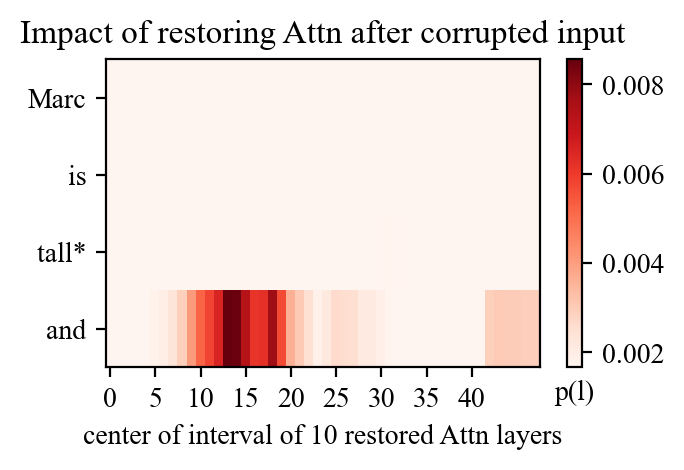

In [127]:
plot_all_flow(mt, "Marc is tall and", subject="tall", noise=0.3)

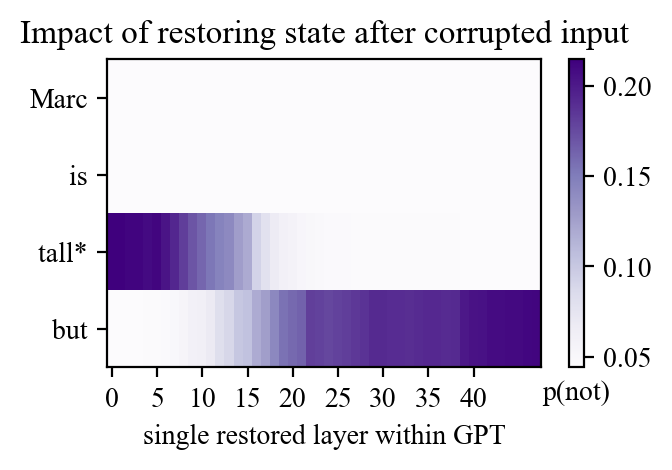

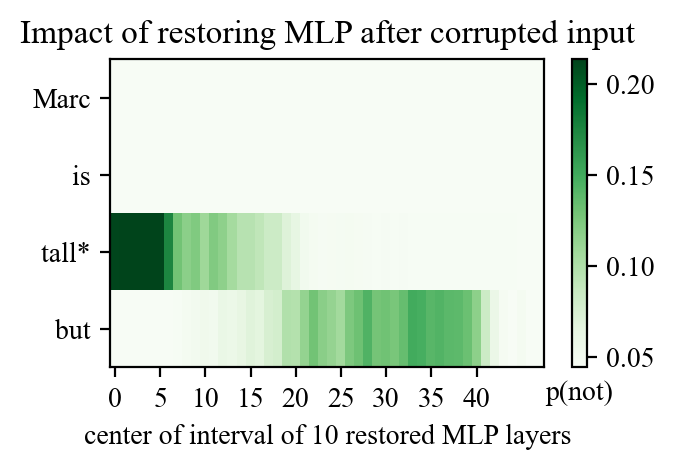

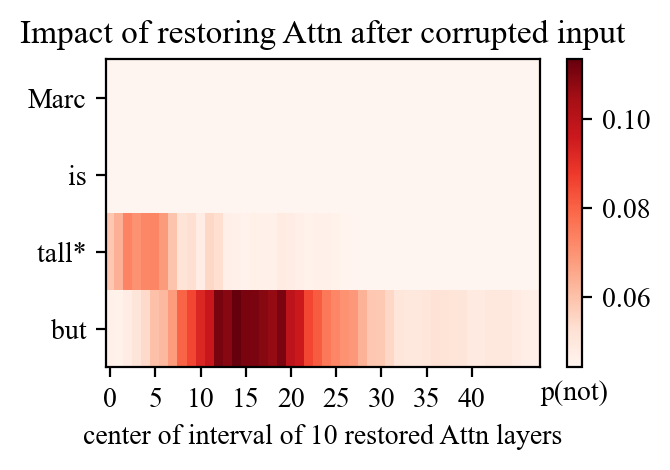

In [128]:
plot_all_flow(mt, "Marc is tall but", subject="tall", noise=0.3)

## Comparison of two adjectives

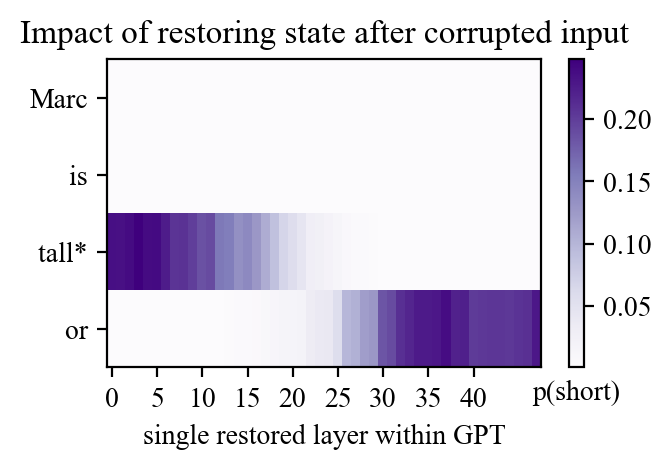

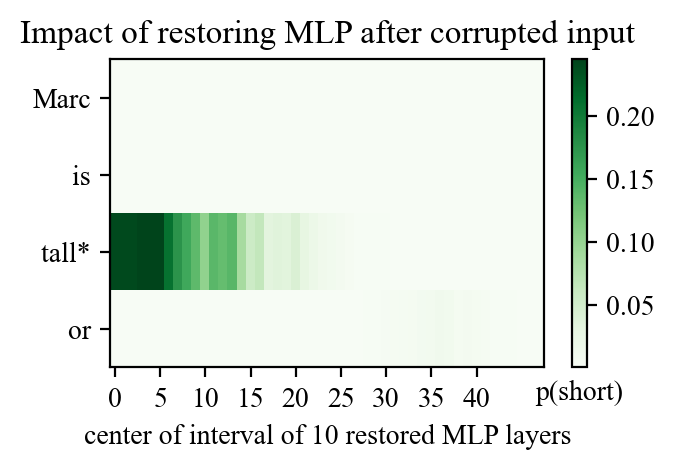

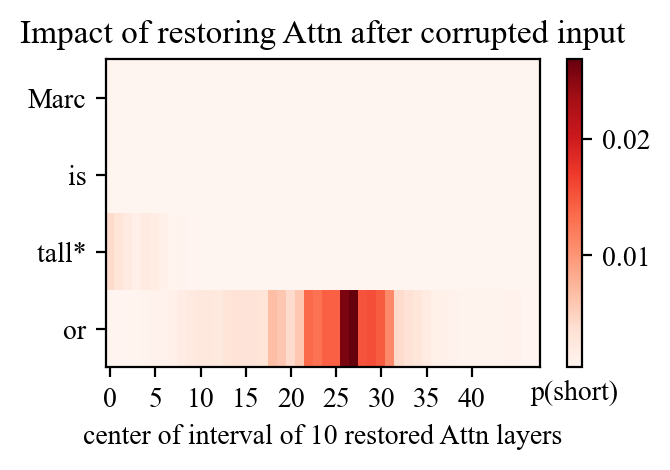

In [100]:
plot_all_flow(mt, "Marc is tall or", subject="tall", noise=0.3)

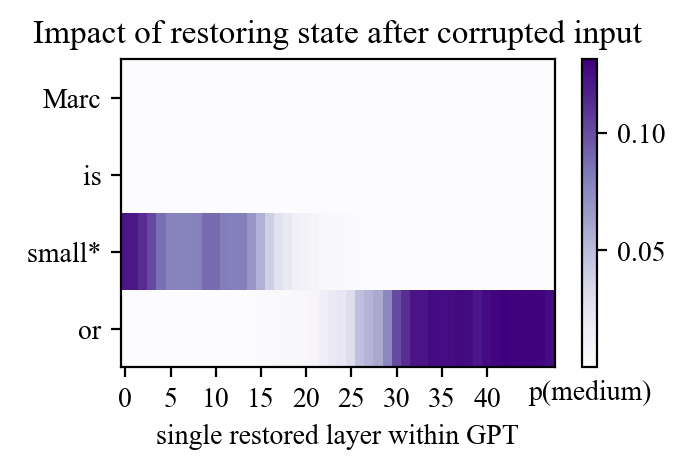

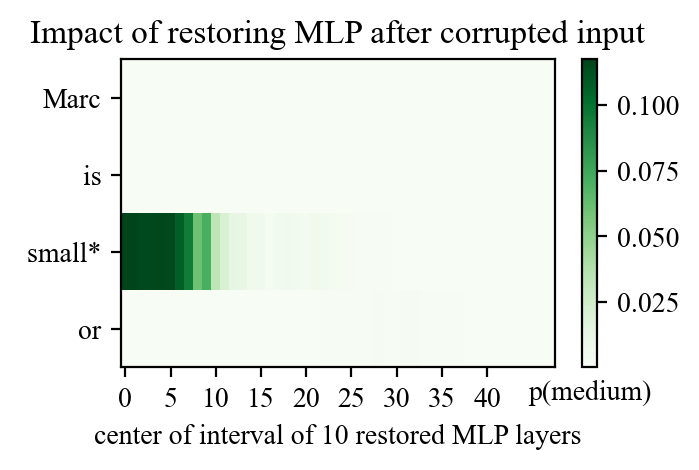

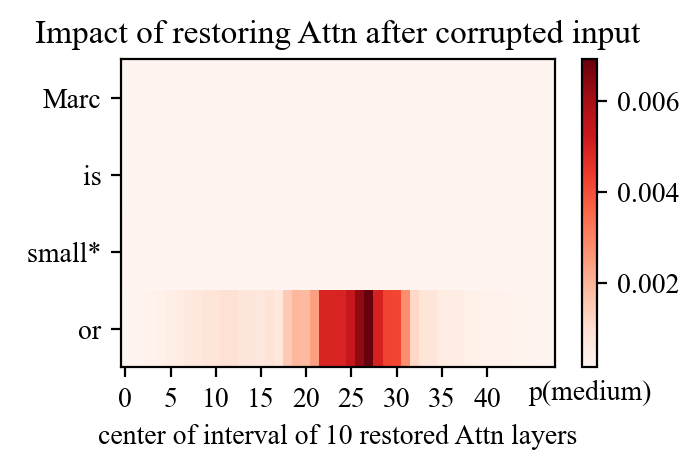

In [105]:
plot_all_flow(mt, "Marc is small or", subject="small", noise=0.3)

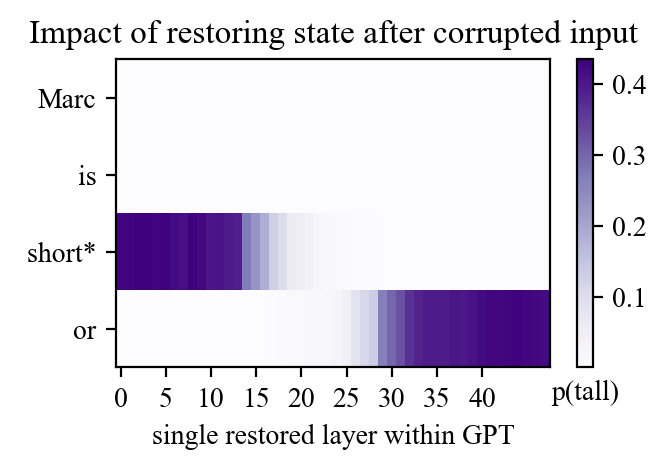

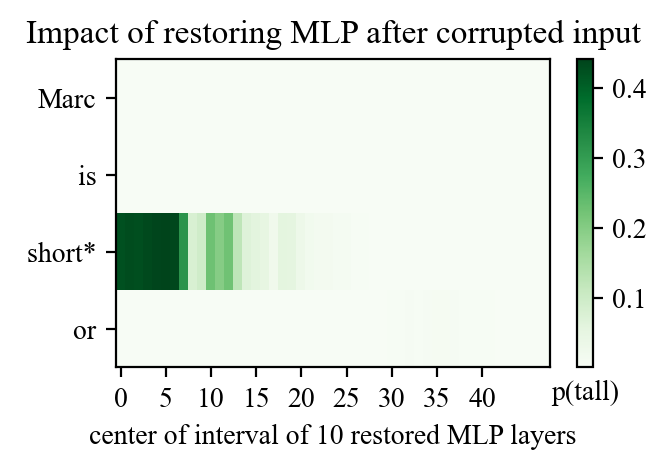

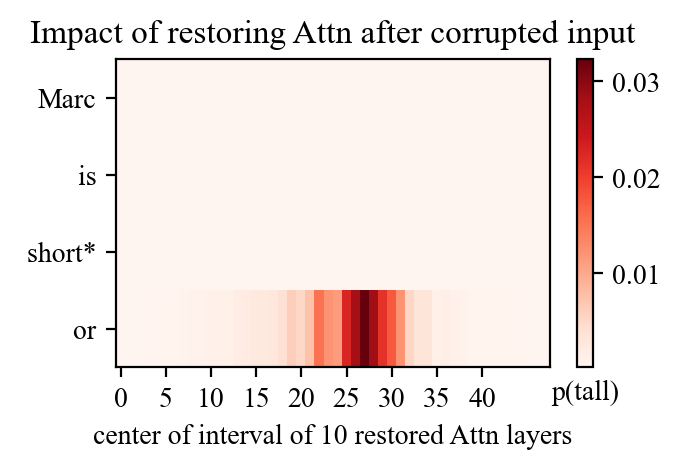

In [106]:
plot_all_flow(mt, "Marc is short or", subject="short", noise=0.3)

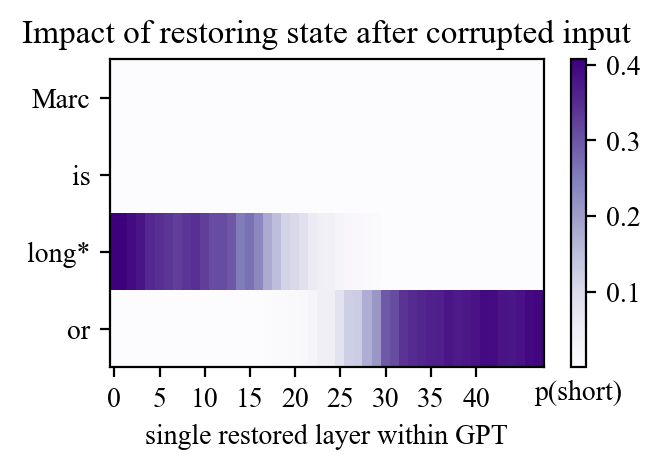

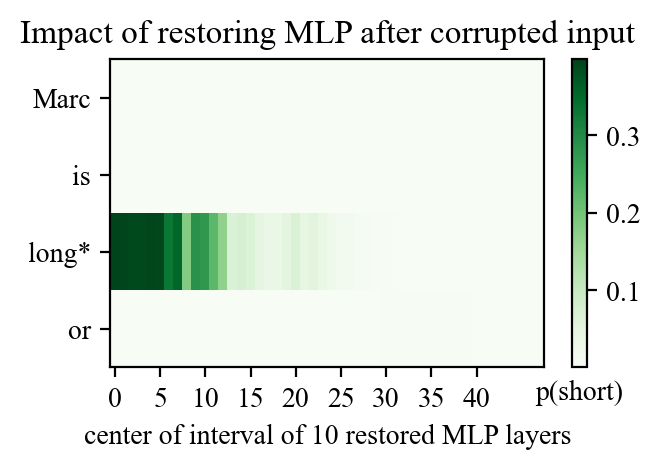

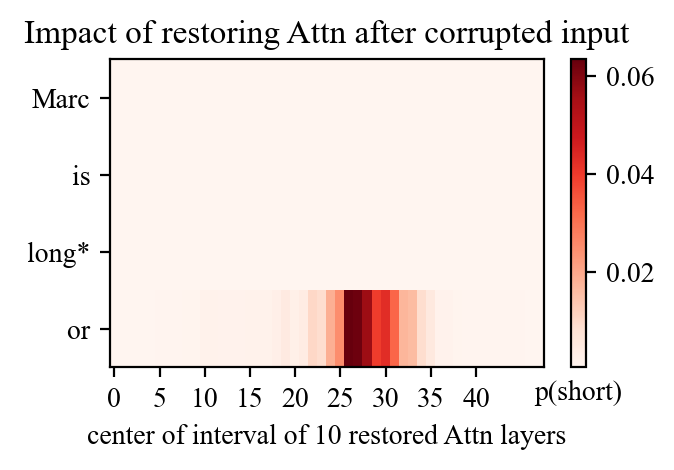

In [107]:
plot_all_flow(mt, "Marc is long or", subject="long", noise=0.3)

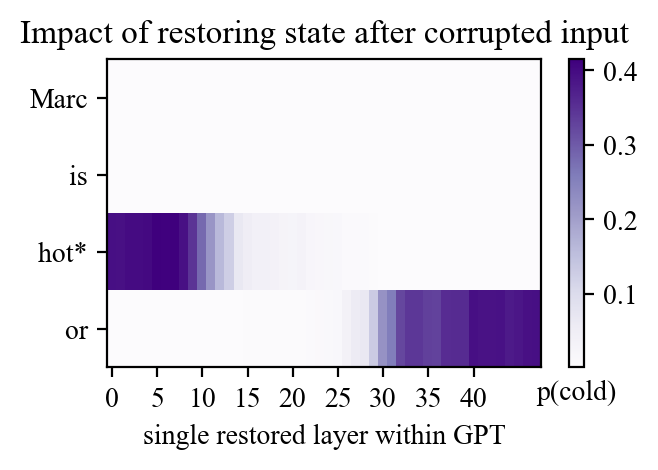

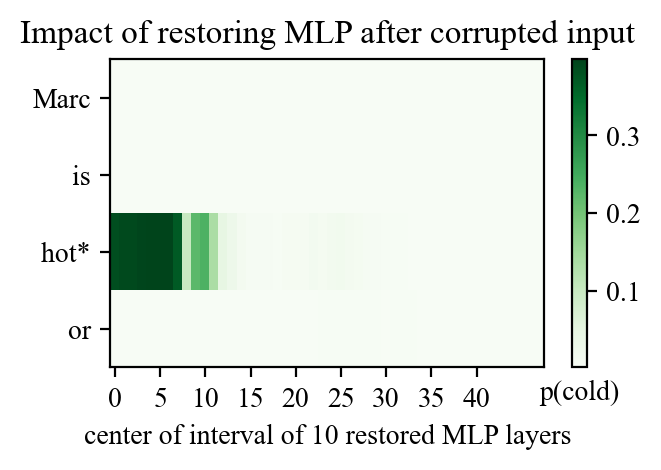

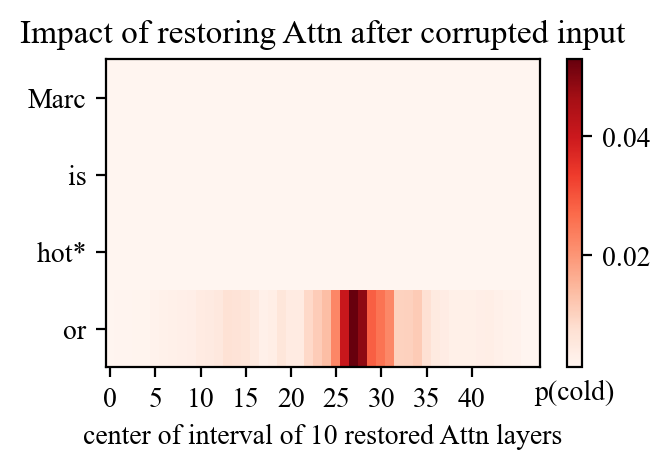

In [108]:
plot_all_flow(mt, "Marc is hot or", subject="hot", noise=0.3)

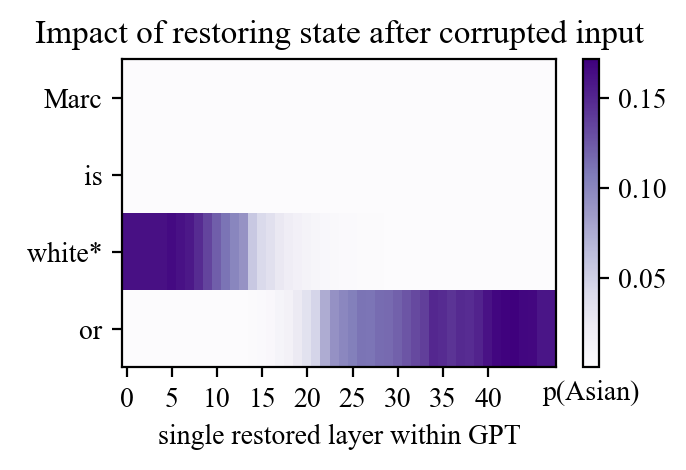

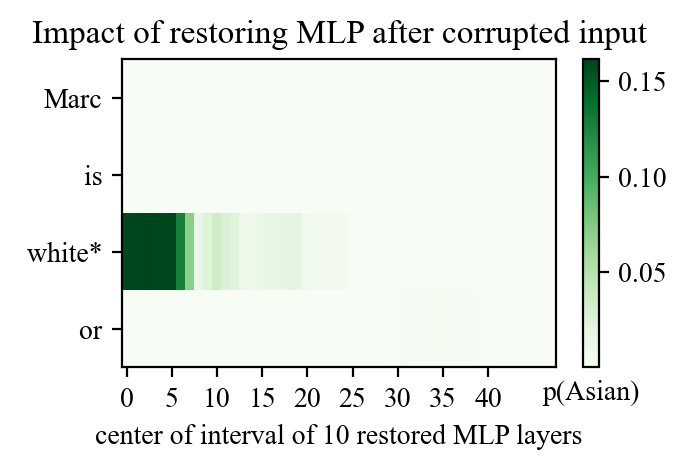

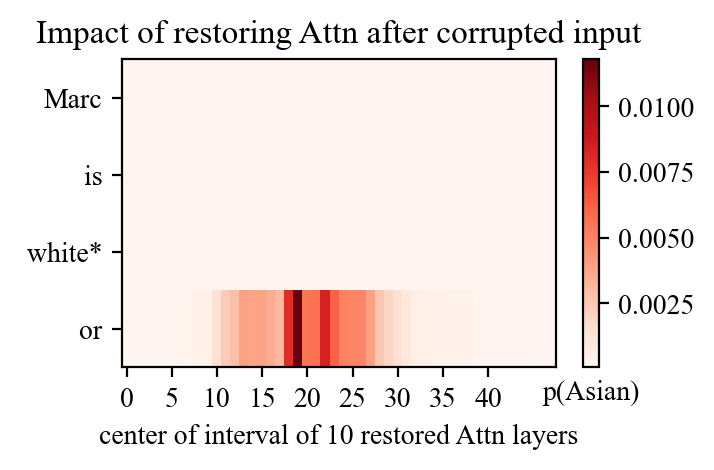

In [110]:
plot_all_flow(mt, "Marc is white or", subject="white", noise=0.3)

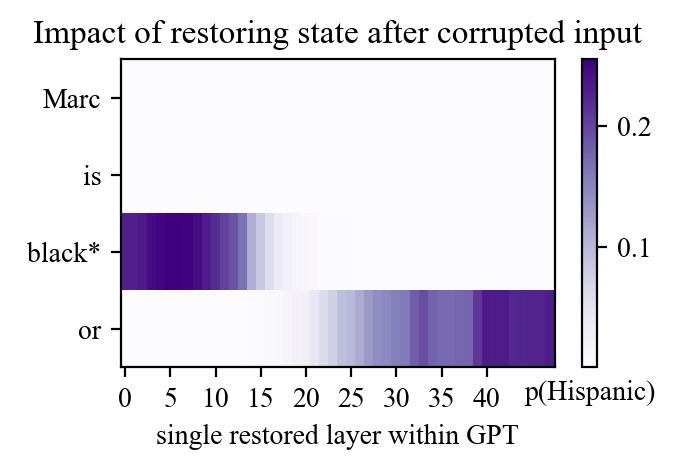

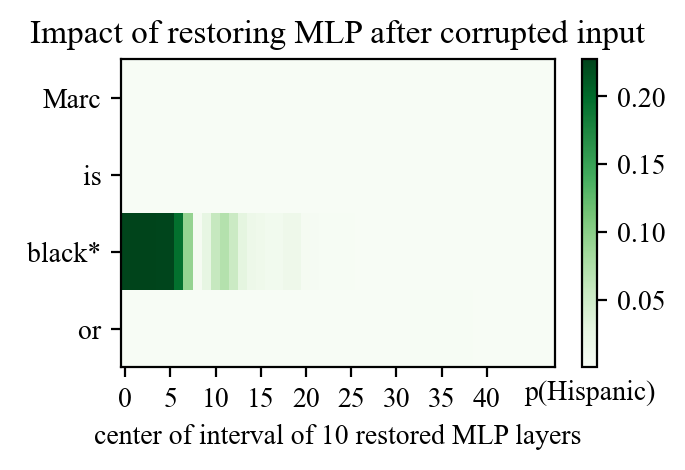

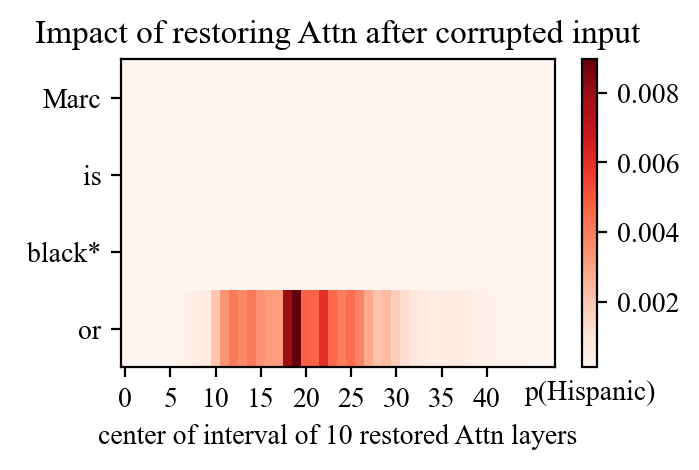

In [112]:
plot_all_flow(mt, "Marc is black or", subject="black", noise=0.3)

We see a correlation between the position of the sensitive attention heads and the similarity (/synonymy) clusters !
I.e. we see that the ...

## Other

In [ ]:
plot_all_flow(mt, "Marc and Kevin are tall and", subject="Marc", noise=0.3)


In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from src.custom.trace import plot_all_flow_v2

In [ ]:
plot_all_flow_v2(mt, "Nadia is strong and", subject="strong", target="powerful", noise=0.2)

In [ ]:
highest_n(get_probas("To be or"), 10)